# Preprocessing

In [24]:
import csv
import numpy as np
import pandas as pd
import neurokit2 as nk
import mne
from scipy.signal import hilbert
import seeg_library as slib
import seeg_constants as CONST
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from datetime import datetime
from tensorpac import Pac

In [28]:
# Constants
patient = 'p8'
event = 2  # On what even to align stroop tasks. Choose "start" (trial start), "stim" (stimulus onset), or "key" (keypress)
alignment = "center"  # Choose "center" or "left"
width = 1000  # Trials will be this long (in ms)
start_time = 0  # Start measuring width from this time
root = "/Users/dravinraj326/Downloads/uPNC 2024/" #CAN BE CHANGED

In [29]:
#Collect patient metadata
subject = CONST.Subject(patient)
region = subject.amcc
probes = len(region)
dim = int(np.ceil(np.sqrt(probes)))
e_map = subject.E_MAP
num_stroop_exp = subject.NUM_STROOP
if event == 1:
    event_name = "stim"
elif event == 2:
    event_name = "key"
else:
    event_name = "start"

In [30]:
edf_path = edf_path = root + patient + "/" + patient + ".edf"
csv_path = root + patient + "/behavior/" + patient + "_"
npy_path = patient + "_trials_" + alignment + str(width) + "_" + event_name + ".npy"
ch_path = patient + "_ch.csv"
augmented_csv_path = patient + "_behavior_" + alignment + str(width) + "_" + event_name + ".csv"

In [31]:
data = mne.io.read_raw_edf(edf_path, preload=True)
channels = slib.create_channel_dict(data.ch_names)
n_chan = len(channels)
exp_times = slib.get_exp_endpoints(data, subject.NUM_EXP, patient)
print(exp_times)

Extracting EDF parameters from /Users/dravinraj326/Downloads/uPNC 2024/p8/p8.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2900095  =      0.000 ...  2832.124 secs...
[(297818, 567804), (627466, 861936), (927029, 1121641), (1178725, 1384603), (1456986, 1655915), (1704343, 1899751), (1944372, 2144180), (2175441, 2379426)]


<Info | 8 non-empty values
 bads: []
 ch_names: A'1, A'2, A'3, A'4, A'5, A'6, A'7, A'8, A'9, A'10, B'1, B'2, ...
 chs: 148 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: 2024-02-22 13:24:42 UTC
 nchan: 148
 projs: []
 sfreq: 1024.0 Hz
 subject_info: 4 items (dict)
>
No annotations found.


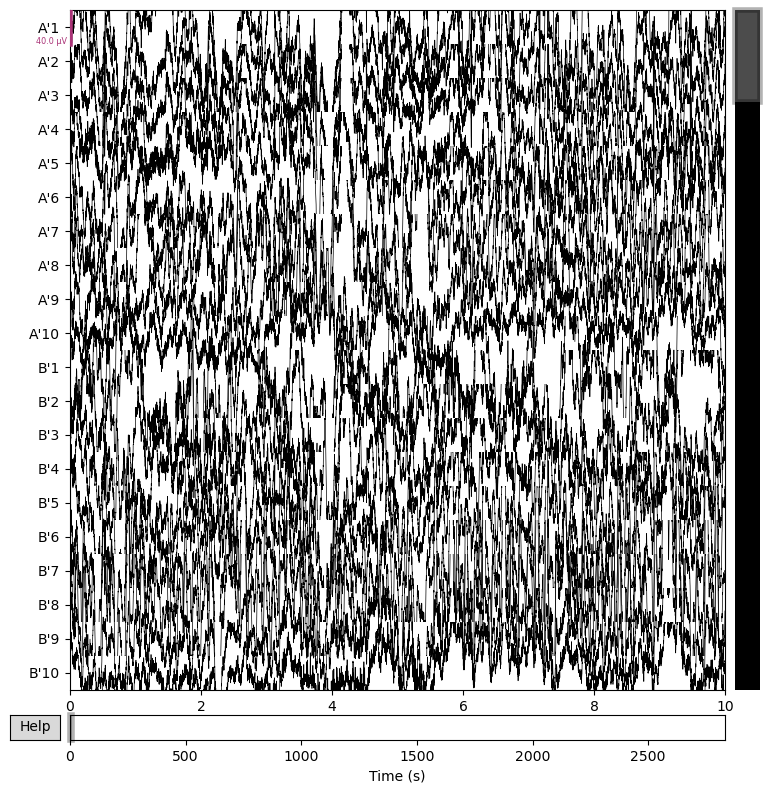

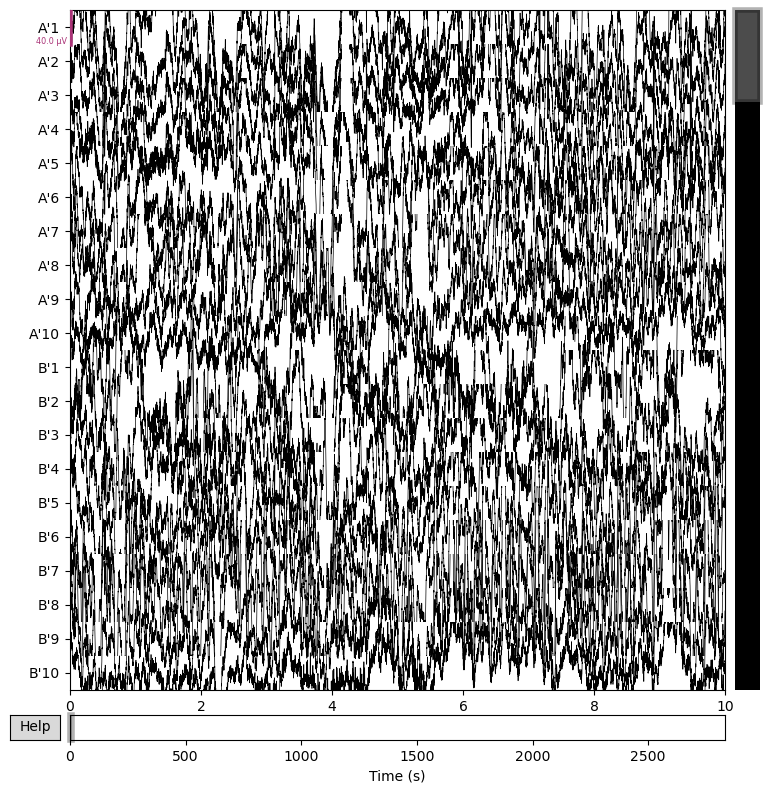

In [32]:
# Print information about the raw data
print(data.info)

# Check for annotations
if data.annotations:
    print("Annotations found:")
    for annotation in data.annotations:
        print(f"Description: {annotation['description']}, Onset: {annotation['onset']}, Duration: {annotation['duration']}")
else:
    print("No annotations found.")

# Plot the raw data to visually inspect the event markers
data.plot()

# EEG Power in Frequency Bands

From fastest to slowest:

Gamma (30-80 Hz)

Beta (13-30 Hz): Strongest in the frontocentral regions.

Beta 1 (13–16 Hz)

Beta 2 (16–20 Hz)

Beta 3 (20–28 Hz)

SMR (13-15 Hz): Sensorimotor rhythm over the sensorimotor cortex. SMR typically decreases in amplitude when the corresponding sensory or motor areas are activated.

Alpha (8-13 Hz): Strongest in the occipital areas at the back of the scalp (visual cortex). Alpha power is assumed to be inversely related to cortical activation. Alpha power could be regarded as an index of top-down processing, representing a mechanism for increasing the signal-to-noise ratio.

Mu (9-11 Hz): The mu rhythm can be found in the frontoparietal region: over the motor cortex, in a band approximately from ear to ear.

Theta (4-8 Hz): Midline theta is usually maximal in the frontal or fronto-central regions.

Delta (1-4 Hz): Strongest in frontal areas. Inhibition of the sensory afferences (Harmony, 2013).



Epochs

In [43]:
# # Read in data
# behavior_df = pd.read_csv(augmented_csv_path)
# with open(npy_path, 'rb') as f:
#     trials = np.load(f)
# channels_raw = next(csv.DictReader(open(ch_path)))
# channels = {i: int(j) for i, j in channels_raw.items()}
# event_id = {'congruent': 1, 'incongruent': 0}  # Events dictionary

# # Average trials by congruency
# congruency = behavior_df['congruent'].to_numpy()
# color = behavior_df['color']


# # Choose stimuli by congruency binary label
# c_idx = np.where(congruency == 1)[0]
# nc_idx = np.where(congruency == 0)[0] 
# # # Choose stimuli by word color
# # c_idx = np.where(color.str.find('blue').to_numpy() == 0)[0]
# # nc_idx = np.where(color.str.find('green').to_numpy() == 0)[0]
# # Ensure indices are within bounds
# c_idx = c_idx[c_idx < trials.shape[0]]
# nc_idx = nc_idx[nc_idx < trials.shape[0]]

# c_trials_sliced = trials[c_idx, :, start_time:width]

# # Create epochs by averaging trials
# c_trials = np.mean(trials[c_idx, :, start_time:width], axis=0)
# nc_trials = np.mean(trials[nc_idx, :, start_time:width], axis=0)

# # Convert to NDArray of integers
# c_trials_int = c_trials.astype(int)
# nc_trials_int = nc_trials.astype(int)

# print(c_trials_sliced)


# # Combine all events arrays from each experiment
# events = np.concatenate(c_trials_int, axis=0)
# events = events.astype(int)


# tmin = -0.2  # start of each epoch (200ms before the event)
# tmax = 1.5

# # Plotting
# epochs = mne.Epochs(data, events, event_id, tmin, tmax, baseline=(None, 0), preload=True, event_repeated='drop')
# epochs.plot(n_epochs=10, events=True)
# plt.show()

# #Create epochs for congruent trials
# epochs_congruent = mne.Epochs(data, events=c_trials_int, event_id=1, tmin=tmin, tmax=tmax, baseline=None, preload=True, event_repeated='drop')

# #Create epochs for incongruent trials
# epochs_incongruent = mne.Epochs(data, events=nc_trials_int, event_id=0, tmin=tmin, tmax=tmax, baseline=None, preload=True, event_repeated='drop')  

In [44]:
# events_file_path = augmented_csv_path
# events_df = pd.read_csv(events_file_path)
# events_df.drop(columns = ['response', 'correct', 'isi'], inplace=True)

# num_experiments = num_stroop_exp

# for i in range(num_experiments):
#     events_df_start_time = events_df.loc[i*40, 'stim_time']
#     if len(events_df_start_time) > 7:
#         time_format = "%H:%M:%S.%f"
#     else:
#         time_format = "%M:%S.%f"
#     events_df_start_time = datetime.strptime(events_df_start_time, time_format)
#     for j in range(40):
#         current_row_index = i*40 + j
#         current_time = events_df.loc[current_row_index, 'stim_time']
#         current_time = datetime.strptime(current_time, time_format)
#         events_df.loc[current_row_index, 'event_time'] = (current_time-events_df_start_time).total_seconds()

# #print(events_df['event_time'])


# events_df['onset_samples'] = (events_df['event_time'] * data.info['sfreq']).astype(int)


# events = np.array([
#     [row['onset_samples'], 0, row['congruent']]
#     for _, row in events_df.iterrows()
# ])

# event_id = {'congruent': 1, 'incongruent': 0} #events dictionary

# tmin = -0.2  # start of each epoch (200ms before the event)
# tmax = 1.5

# #picks = mne.pick_types(data.info, meg=False, eeg=True, eog=False, stim=False)
# epochs = mne.Epochs(data, events, event_id, tmin, tmax, baseline=(None, 0), preload=True, event_repeated='drop')
# epochs.plot(n_epochs=10, events=True)
# plt.show()

0
1
2
3
4
5
6
7
Not setting metadata
319 matching events found
Setting baseline interval to [-0.2001953125, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 319 events and 1742 original time points ...
0 bad epochs dropped
You seem to have overlapping epochs. Some event lines may be duplicated in the plot.


/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/486192615.py:75: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(data, events, event_id, tmin, tmax, baseline=(None, 0), preload=True, event_repeated='drop')


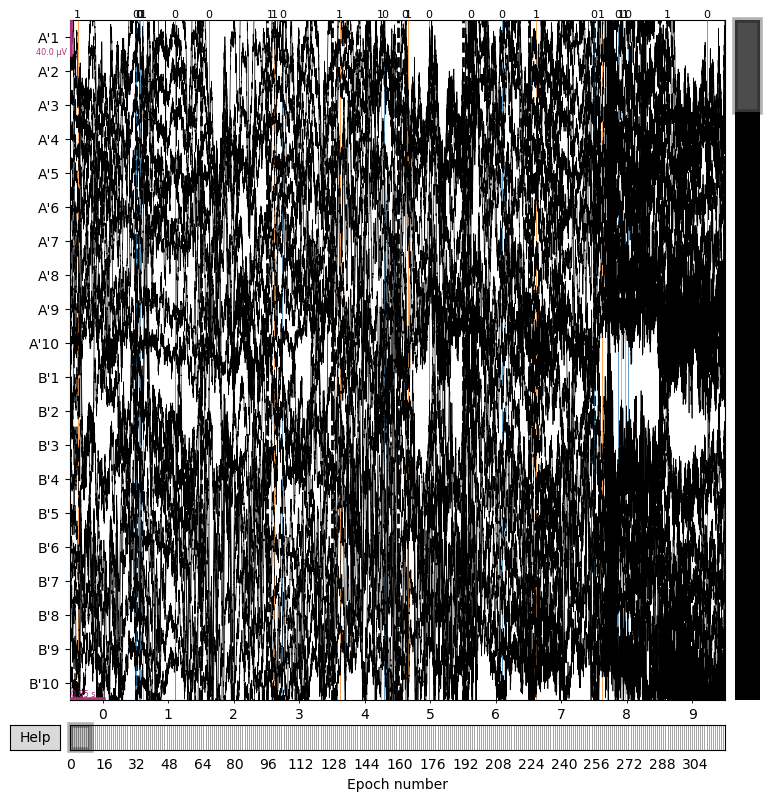

Not setting metadata
179 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 179 events and 1742 original time points ...
0 bad epochs dropped
Not setting metadata
140 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 140 events and 1742 original time points ...
0 bad epochs dropped


/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/486192615.py:80: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs_congruent = mne.Epochs(data, events, event_id=1, tmin=tmin, tmax=tmax, baseline=None, preload=True, event_repeated='drop')
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/486192615.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs_incongruent = mne.Epochs(data, events, event_id=0, tmin=tmin, tmax=tmax, baseline=None, preload=True, event_repeated='drop')


In [33]:
trial_start_indices_lst = []  # List to store indices for all experiments
# Create dataset of all trials
df_lst = []
trial_lst = []
events_lst = []  # List to collect event data
event_id = {'congruent': 1, 'incongruent': 0}  # Events dictionary

for i in range(num_stroop_exp):
    print(i)
    # Read in and augment behavior data
    experiment = "stroop" + str(i + 1)
    path_csv = csv_path + experiment + ".csv"
    if patient == "p2":
        df = slib.augment_stroop_behavior_df(path_csv)
    else:
        df = slib.read_csv_file(path_csv)
    df_lst.append(df)

    # Read in raw data
    experiment_id = e_map[experiment]
    raw_data = data.get_data(start=exp_times[experiment_id][0], stop=exp_times[experiment_id][1])
    trig_chan = raw_data[channels["TRIG"]]

    if patient == "p2":
        stroop_lbl = slib.label_stroop_events_july17(trig_chan)
    else:
        stroop_lbl = slib.label_stroop_events(trig_chan)

    # Collect trials based on event
    trial_start = stroop_lbl.loc[stroop_lbl['Event'] == event]['Time'].to_numpy()
    trial_start_indices_for_exp = []  # List to store indices for this experiment

    for ts in trial_start:
        # Find index of trial start time
        index = stroop_lbl[stroop_lbl['Time'] == ts].index
        if len(index) > 0:
            trial_start_indices_for_exp.append(index[0])
        else:
            trial_start_indices_for_exp.append(None)  # If no match found

    trial_start_indices_lst.append(trial_start_indices_for_exp)

    num_trials = len(trial_start)
    trial_arr = np.zeros((num_trials, int(raw_data.shape[0]), width))

    idx_start = 0 if alignment == 'left' else 1
    for j in np.arange(idx_start, num_trials - 1):
        event_time = int(trial_start[j])
        if alignment == 'left':
            s1 = event_time
            s2 = event_time + width
        elif alignment == 'center':
            s1 = int(event_time - width / 2)
            s2 = int(event_time + width / 2)
        sig = 10**6 * raw_data[:, s1:s2]  # Get signal in uV
        trial_arr[j, :, :] = slib.band_noise_filter(sig, lower=0.1)
    
    trial_lst.append(trial_arr)

    # Construct events array for this experiment
    events_arr = np.array([
        [stroop_lbl.loc[index]['Time'], 0, df['congruent'].iloc[j]]  # Assuming event index, zero, and congruency are needed
        for j, index in enumerate(trial_start_indices_for_exp)
    ])
    events_lst.append(events_arr) 

# Combine all events arrays from each experiment
events = np.concatenate(events_lst, axis=0)
events = events.astype(int)

tmin = -0.2  # start of each epoch (200ms before the event)
tmax = 1.5

# Plotting
epochs = mne.Epochs(data, events, event_id, tmin, tmax, baseline=(None, 0), preload=True, event_repeated='drop')
epochs.plot(n_epochs=10, events=True)
plt.show()

#Create epochs for congruent trials
epochs_congruent = mne.Epochs(data, events, event_id=1, tmin=tmin, tmax=tmax, baseline=None, preload=True, event_repeated='drop')

#Create epochs for incongruent trials
epochs_incongruent = mne.Epochs(data, events, event_id=0, tmin=tmin, tmax=tmax, baseline=None, preload=True, event_repeated='drop')


Power Spectrogram

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)


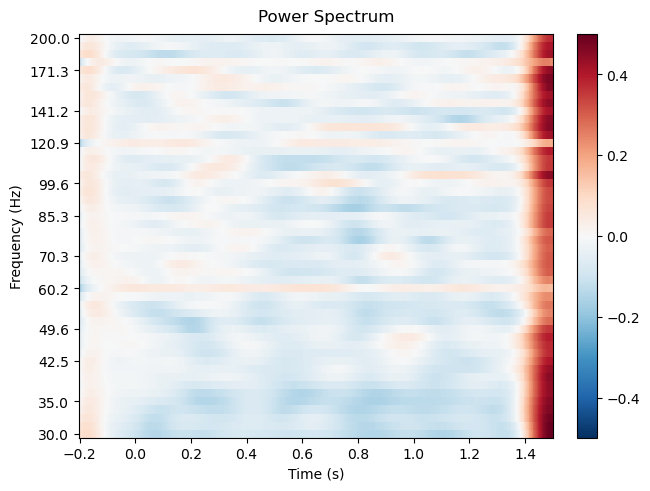

In [31]:
frequencies = np.logspace(*np.log10([30, 200]), num=50)  # define frequencies from 6 to 30Hz
n_cycles = frequencies / 2.  # different number of cycles per frequency

power = mne.time_frequency.tfr_morlet(epochs, freqs=frequencies, n_cycles=n_cycles, use_fft=True,
                                      return_itc=False, decim=3, n_jobs=1)

# Plot the results
power.plot([0], baseline=(None, 0), mode='logratio', title='Power Spectrum')
plt.show()

Evoked Responses

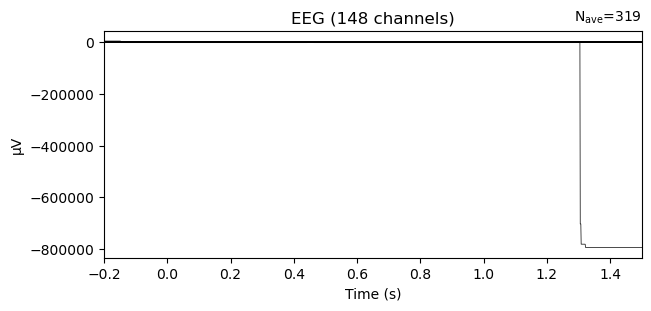

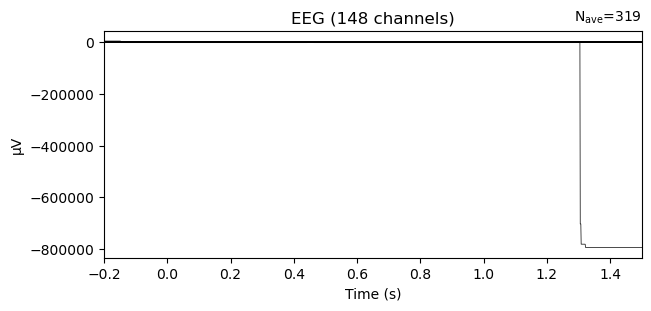

In [32]:
# Optionally, process the epochs further (e.g., compute evoked responses)
evoked_trigger = epochs.average()
evoked_trigger.plot()

# Channel Index Finder!

In [36]:
# Define the value to search for
channel_of_interest = ["TRIG"]
print(data.ch_names)

# Check if the channel is present in the data
if channel_of_interest[0] in data.ch_names:
    channel_index = data.ch_names.index(channel_of_interest[0])
    print(f"Index of channel {channel_of_interest[0]}: {channel_index}")
else:
    print(f"Channel {channel_of_interest[0]} not found in the data.")

["A'1", "A'2", "A'3", "A'4", "A'5", "A'6", "A'7", "A'8", "A'9", "A'10", "B'1", "B'2", "B'3", "B'4", "B'5", "B'6", "B'7", "B'8", "B'9", "B'10", "C'1", "C'2", "C'3", "C'4", "C'5", "C'6", "C'7", "C'8", "C'9", "C'10", "F'1", "F'2", "F'3", "F'4", "F'5", "F'6", "F'7", "F'8", "G'1", "G'2", "G'3", "G'4", "G'5", "G'6", "G'7", "G'8", "G'9", "G'10", "G'11", "G'12", "I'1", "I'2", "I'3", "I'4", "I'5", "I'6", "I'7", "I'8", "I'9", "I'10", "O'1", "O'2", "O'3", "O'4", "O'5", "O'6", "O'7", "O'8", "O'9", "O'10", "O'11", "O'12", "U'1", "U'2", "U'3", "U'4", "U'5", "U'6", "U'7", "U'8", "Y'1", "Y'2", "Y'3", "Y'4", "Y'5", "Y'6", "Y'7", "Y'8", "Y'9", "Y'10", "Y'11", "Y'12", 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'C113', 'C114', 'C115', 'C116', 'C117', 'C118', 'C119', 'C120', 'C121', 'C122', 'C123', 'C124', 'C125', 'C126', 'C127', 'C128', 'DC1', 'DC2', 'DC3', 'DC4', 'DC5', 'DC6', 'DC7', 'DC8', 'DC9', 'DC10', 'DC11', 'DC12', 'DC13

# Power Spectral Density

All Frequency Bands

Effective window size : 2.000 (s)


/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_23942/2748629521.py:2: RuntimeWarning: divide by zero encountered in log10
  psds_db = 10 * np.log10(psd) # Convert to dB from dB/Hz


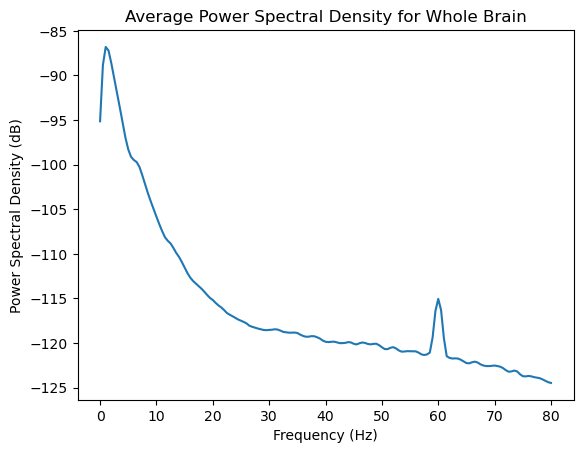

In [278]:
psd, freqs = mne.time_frequency.psd_array_welch(data._data, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
psds_db = 10 * np.log10(psd) # Convert to dB from dB/Hz

plt.plot(freqs, psds_db[0])  
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('Average Power Spectral Density for Whole Brain')
plt.show()

- All Trials

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)


/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_42766/244618230.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  for epoch in epochs.get_data():


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

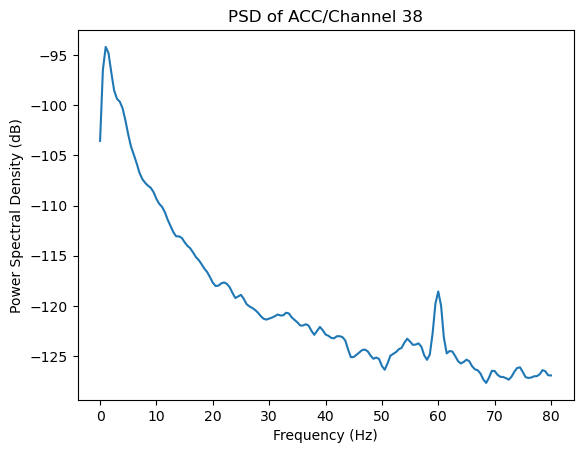

In [57]:
#ANTERIOR CINGULATE CORTEX

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in epochs.get_data():
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# psds is in shape (n_epochs, n_channels, n_freqs)
print(f"PSDs shape: {psds.shape}")
print(f"Frequencies shape: {freqs.shape}")

# Specify the channel you want to analyze
specific_channel = 38  # Change this to the brain area you want to analyze

# Extract general band data
gen_psds = psds[:, specific_channel, :]

# Average general PSD across epochs and channels for a more comprehensive view
gen_psd_mean = gen_psds.mean(axis=0)

# Plotting the average theta PSD
plt.plot(freqs, 10 * np.log10(gen_psd_mean))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD of ACC/Channel {}'.format(specific_channel))
plt.show()

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_42766/353086017.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  for epoch in epochs.get_data():


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

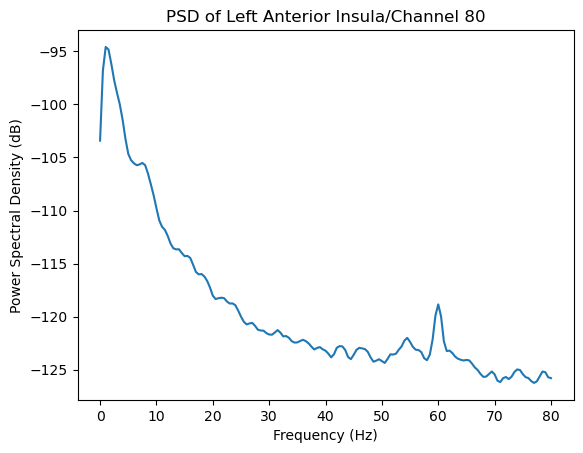

In [58]:
#LEFT ANTERIOR INSULA

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in epochs.get_data():
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# psds is in shape (n_epochs, n_channels, n_freqs)
print(f"PSDs shape: {psds.shape}")
print(f"Frequencies shape: {freqs.shape}")

# Specify the channel you want to analyze
specific_channel = 80  # Change this to the brain area you want to analyze

# Extract general band data
gen_psds = psds[:, specific_channel, :]

# Average general PSD across epochs and channels for a more comprehensive view
gen_psd_mean = gen_psds.mean(axis=0)

# Plotting the average general PSD
plt.plot(freqs, 10 * np.log10(gen_psd_mean))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD of Left Anterior Insula/Channel {}'.format(specific_channel))
plt.show()

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_42766/71199217.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  for epoch in epochs.get_data():


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

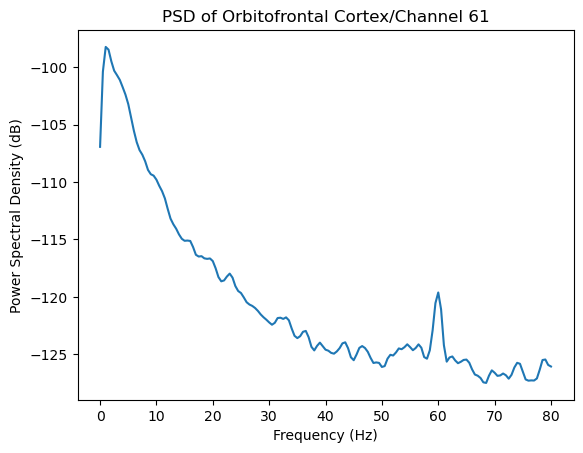

In [73]:
#ORBITOFRONTAL CORTEX

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in epochs.get_data():
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# psds is in shape (n_epochs, n_channels, n_freqs)
print(f"PSDs shape: {psds.shape}")
print(f"Frequencies shape: {freqs.shape}")

# Specify the channel you want to analyze
specific_channel = 61  # Change this to the brain area you want to analyze

# Extract general band data
gen_psds = psds[:, specific_channel, :]

# Average general PSD across epochs and channels for a more comprehensive view
gen_psd_mean = gen_psds.mean(axis=0)

# Plotting the average general PSD
plt.plot(freqs, 10 * np.log10(gen_psd_mean))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD of Orbitofrontal Cortex/Channel {}'.format(specific_channel))
plt.show()

- Congruent

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)


/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/3760297348.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_congruent = epochs_congruent.get_data()


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

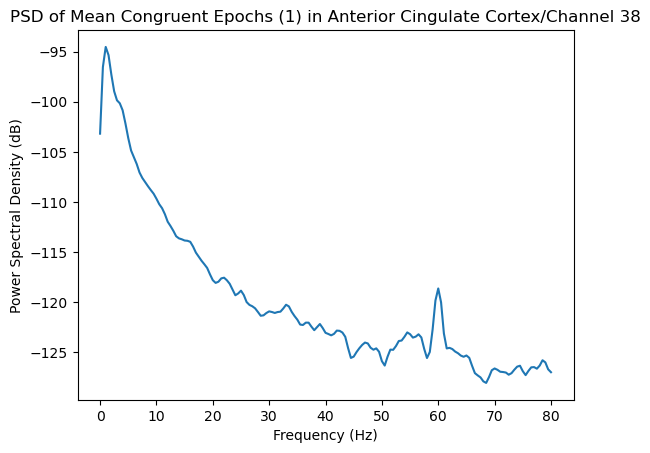

In [48]:
#ANTERIOR CINGULATE CORTEX

# Extract data from epochs
data_congruent = epochs_congruent.get_data()

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in data_congruent:
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# Specify the channel you want to analyze
specific_channel = 38  # Change this to the index of the channel you want to analyze

# Compute the mean of all congruent epochs for the specified channel
mean_congruent = psds[:, specific_channel, :].mean(axis=0)

# Plot the PSD for the theta band
plt.plot(freqs, 10 * np.log10(mean_congruent))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD of Mean Congruent Epochs (1) in Anterior Cingulate Cortex/Channel {}'.format(specific_channel))
plt.show()

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)


/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/1901900500.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_congruent = epochs_congruent.get_data()


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

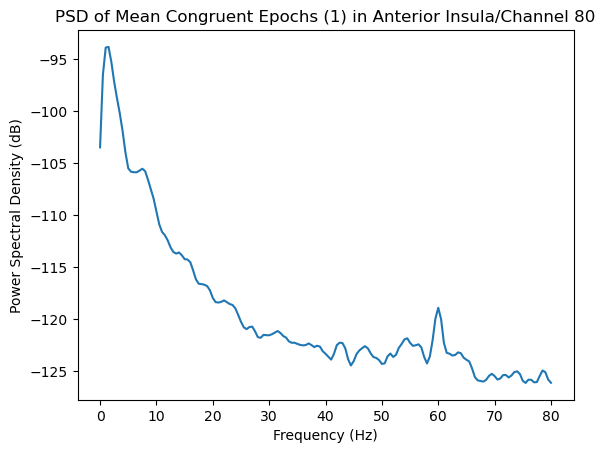

In [50]:
#ANTERIOR INSULA

# Extract data from epochs
data_congruent = epochs_congruent.get_data()

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in data_congruent:
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# Specify the channel you want to analyze
specific_channel = 80  # Change this to the index of the channel you want to analyze

# Compute the mean of all congruent epochs for the specified channel
mean_congruent = psds[:, specific_channel, :].mean(axis=0)

# Plot the PSD for the theta band
plt.plot(freqs, 10 * np.log10(mean_congruent))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD of Mean Congruent Epochs (1) in Anterior Insula/Channel {}'.format(specific_channel))
plt.show()

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/782962560.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_congruent = epochs_congruent.get_data()


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

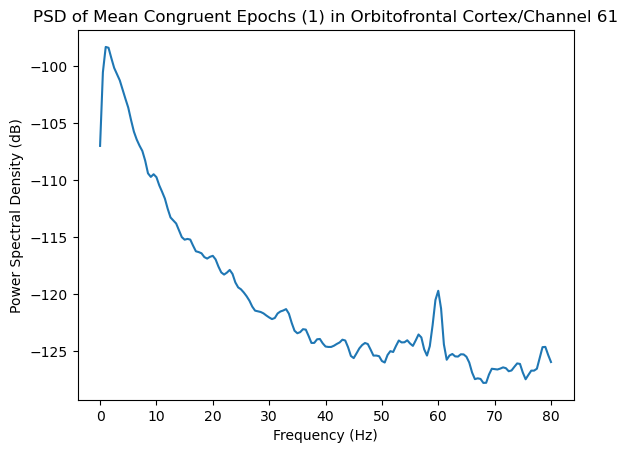

In [51]:
#ORBITOFRONTAL CORTEX

# Extract data from epochs
data_congruent = epochs_congruent.get_data()

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in data_congruent:
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# Specify the channel you want to analyze
specific_channel = 61  # Change this to the index of the channel you want to analyze

# Compute the mean of all congruent epochs for the specified channel
mean_congruent = psds[:, specific_channel, :].mean(axis=0)

# Plot the PSD for the theta band
plt.plot(freqs, 10 * np.log10(mean_congruent))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD of Mean Congruent Epochs (1) in Orbitofrontal Cortex/Channel {}'.format(specific_channel))
plt.show()

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/4043466902.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_congruent = epochs_congruent.get_data()


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

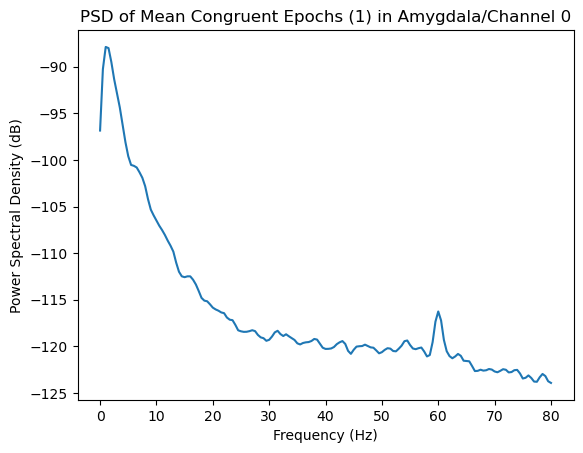

In [52]:
#AMYGDALA

# Extract data from epochs
data_congruent = epochs_congruent.get_data()

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in data_congruent:
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# Specify the channel you want to analyze
specific_channel = 0  # Change this to the index of the channel you want to analyze

# Compute the mean of all congruent epochs for the specified channel
mean_congruent = psds[:, specific_channel, :].mean(axis=0)

# Plot the PSD for the theta band
plt.plot(freqs, 10 * np.log10(mean_congruent))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD of Mean Congruent Epochs (1) in Amygdala/Channel {}'.format(specific_channel))
plt.show()

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/3793575481.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_congruent = epochs_congruent.get_data()


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

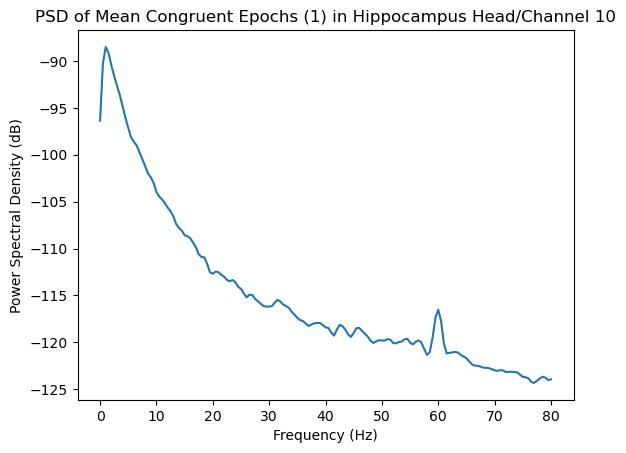

In [56]:
#HIPPOCAMPUS HEAD

# Extract data from epochs
data_congruent = epochs_congruent.get_data()

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in data_congruent:
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# Specify the channel you want to analyze
specific_channel = 10  # Change this to the index of the channel you want to analyze

# Compute the mean of all congruent epochs for the specified channel
mean_congruent = psds[:, specific_channel, :].mean(axis=0)

# Plot the PSD for the theta band
plt.plot(freqs, 10 * np.log10(mean_congruent))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD of Mean Congruent Epochs (1) in Hippocampus Head/Channel {}'.format(specific_channel))
plt.show()

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)


/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/1832089267.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_congruent = epochs_congruent.get_data()


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

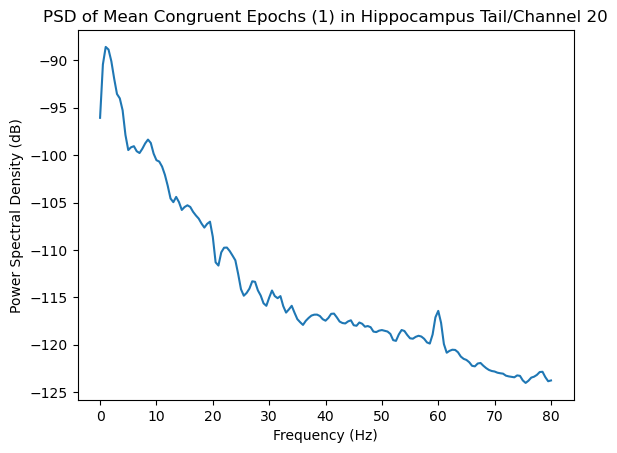

In [57]:
#HIPPOCAMPUS TAIL

# Extract data from epochs
data_congruent = epochs_congruent.get_data()

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in data_congruent:
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# Specify the channel you want to analyze
specific_channel = 20  # Change this to the index of the channel you want to analyze

# Compute the mean of all congruent epochs for the specified channel
mean_congruent = psds[:, specific_channel, :].mean(axis=0)

# Plot the PSD for the theta band
plt.plot(freqs, 10 * np.log10(mean_congruent))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD of Mean Congruent Epochs (1) in Hippocampus Tail/Channel {}'.format(specific_channel))
plt.show()

- Incongruent

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)


/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/2299230339.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_incongruent = epochs_incongruent.get_data()


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

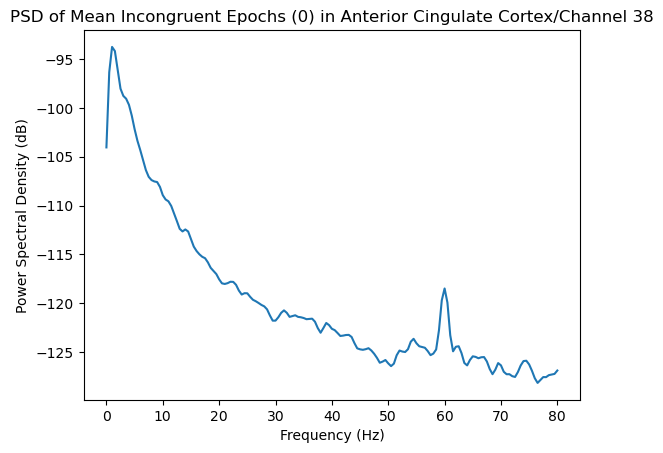

In [58]:
#ANTERIOR CINGULATE CORTEX

# Extract data from epochs
data_incongruent = epochs_incongruent.get_data()

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in data_incongruent:
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# Specify the channel you want to analyze
specific_channel = 38  # Change this to the index of the channel you want to analyze

# Compute the mean of all congruent epochs for the specified channel
mean_incongruent = psds[:, specific_channel, :].mean(axis=0)


# Plot the PSD for the general band
plt.plot(freqs, 10 * np.log10(mean_incongruent))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD of Mean Incongruent Epochs (0) in Anterior Cingulate Cortex/Channel {}'.format(specific_channel))
plt.show()

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/2210038491.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_incongruent = epochs_incongruent.get_data()


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

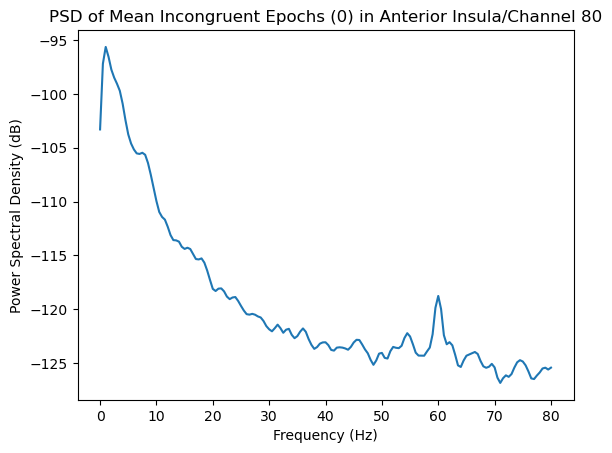

In [59]:
#ANTERIOR INSULA

# Extract data from epochs
data_incongruent = epochs_incongruent.get_data()

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in data_incongruent:
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# Specify the channel you want to analyze
specific_channel = 80  # Change this to the index of the channel you want to analyze

# Compute the mean of all congruent epochs for the specified channel
mean_incongruent = psds[:, specific_channel, :].mean(axis=0)


# Plot the PSD for the general band
plt.plot(freqs, 10 * np.log10(mean_incongruent))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD of Mean Incongruent Epochs (0) in Anterior Insula/Channel {}'.format(specific_channel))
plt.show()

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)


/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/355043330.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_incongruent = epochs_incongruent.get_data()


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

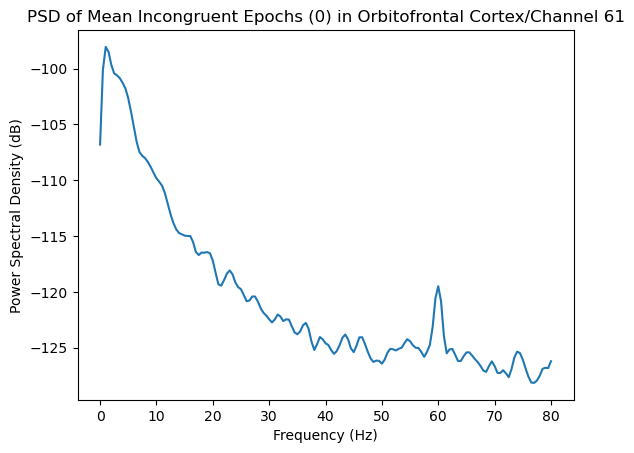

In [64]:
#ORBITOFRONTAL CORTEX

# Extract data from epochs
data_incongruent = epochs_incongruent.get_data()

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in data_incongruent:
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# Specify the channel you want to analyze
specific_channel = 61  # Change this to the index of the channel you want to analyze

# Compute the mean of all congruent epochs for the specified channel
mean_incongruent = psds[:, specific_channel, :].mean(axis=0)


# Plot the PSD for the general band
plt.plot(freqs, 10 * np.log10(mean_incongruent))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD of Mean Incongruent Epochs (0) in Orbitofrontal Cortex/Channel {}'.format(specific_channel))
plt.show()

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/2829011422.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_incongruent = epochs_incongruent.get_data()


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

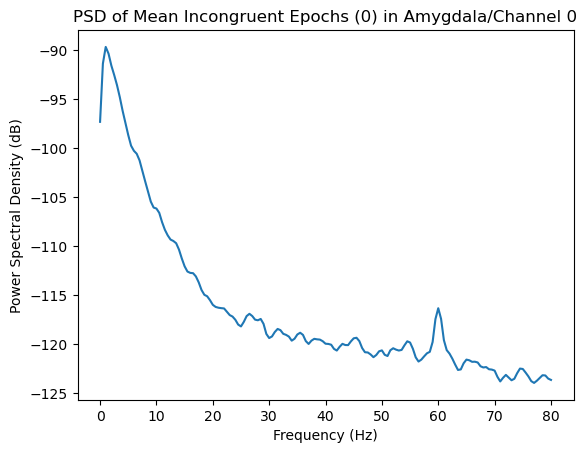

In [61]:
#AMYGDALA

# Extract data from epochs
data_incongruent = epochs_incongruent.get_data()

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in data_incongruent:
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# Specify the channel you want to analyze
specific_channel = 0  # Change this to the index of the channel you want to analyze

# Compute the mean of all congruent epochs for the specified channel
mean_incongruent = psds[:, specific_channel, :].mean(axis=0)


# Plot the PSD for the general band
plt.plot(freqs, 10 * np.log10(mean_incongruent))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD of Mean Incongruent Epochs (0) in Amygdala/Channel {}'.format(specific_channel))
plt.show()

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/3262632824.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_incongruent = epochs_incongruent.get_data()


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

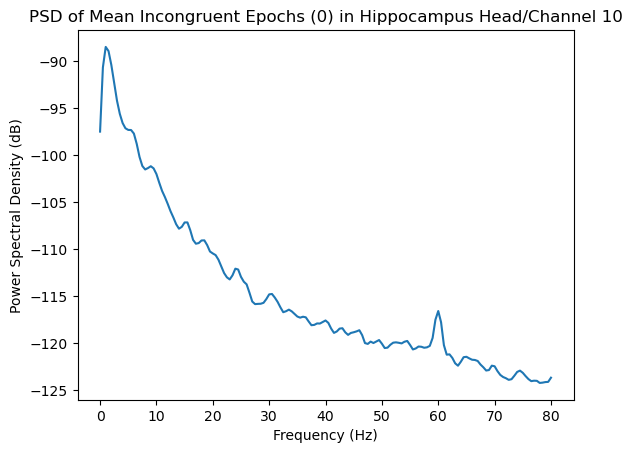

In [62]:
#HIPPOCAMPUS HEAD

# Extract data from epochs
data_incongruent = epochs_incongruent.get_data()

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in data_incongruent:
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# Specify the channel you want to analyze
specific_channel = 10  # Change this to the index of the channel you want to analyze

# Compute the mean of all congruent epochs for the specified channel
mean_incongruent = psds[:, specific_channel, :].mean(axis=0)


# Plot the PSD for the general band
plt.plot(freqs, 10 * np.log10(mean_incongruent))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD of Mean Incongruent Epochs (0) in Hippocampus Head/Channel {}'.format(specific_channel))
plt.show()

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/3786647620.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_incongruent = epochs_incongruent.get_data()


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

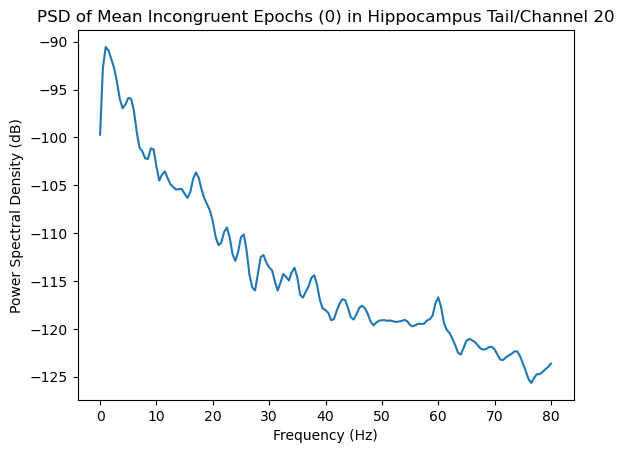

In [63]:
#HIPPOCAMPUS TAIL

# Extract data from epochs
data_incongruent = epochs_incongruent.get_data()

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in data_incongruent:
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# Specify the channel you want to analyze
specific_channel = 20  # Change this to the index of the channel you want to analyze

# Compute the mean of all congruent epochs for the specified channel
mean_incongruent = psds[:, specific_channel, :].mean(axis=0)


# Plot the PSD for the general band
plt.plot(freqs, 10 * np.log10(mean_incongruent))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD of Mean Incongruent Epochs (0) in Hippocampus Tail/Channel {}'.format(specific_channel))
plt.show()

- Overlap Graphs

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- H

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_congruent = epochs_congruent.get_data()
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(6

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/fol

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- H

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer t

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer t

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/fol

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- H

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer t

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer t

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- H

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer t

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/41788

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer t

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/fol

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/41788

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/fol

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/fol

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s


- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, no

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer t

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/fol

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/fol

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/fol

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s


Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- H

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer t

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- H

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer t

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/fol

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/fol

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/fol

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/fol

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/41788

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/fol

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer t

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/fol

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/fol

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/fol

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/fol

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- H

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer t

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/fol

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pas

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer t

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/fol

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/fol

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s


Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- H

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer t

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- H

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer t

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/fol

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/fol

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/41788

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer t

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/fol

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer t

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/fol

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:11: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_incongruent = epochs_incongruent.get_data()
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is lo


Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed tim

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is lo

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is lo

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is lo

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/v

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/v

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is lo

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/v

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is lo

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/v

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is lo

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is lo

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is lo

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is lo

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/v

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is lo

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/v

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is lo

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/v

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is lo

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/v

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is lo

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/v

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/v

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/v

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is lo

- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
--------------------

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is lo

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/v

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/v

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is lo

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/v

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- H

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/4178849068.py:32: RuntimeWarning: filter_length (6759) is lo

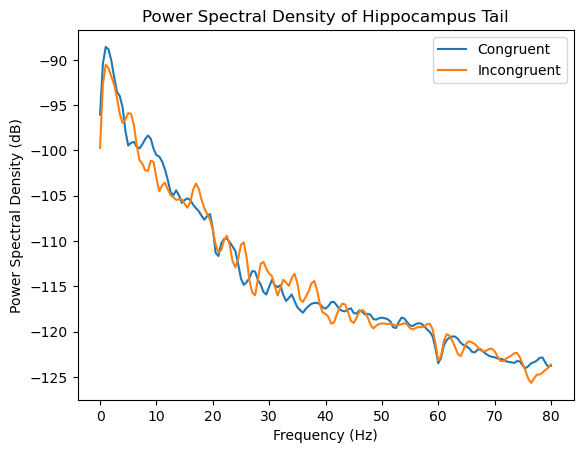

In [35]:
# Extract data from epochs
data_congruent = epochs_congruent.get_data()

# Initialize an empty list to store PSDs
con_psds_list = []

sfreq = epochs_congruent.info['sfreq']

# Compute PSD for each epoch
for epoch_con in data_congruent:
    filtered_data = mne.filter.notch_filter(epoch_con, sfreq, freqs=np.arange(60, 241, 60))
    psd_con, freqs = mne.time_frequency.psd_array_welch(filtered_data, sfreq, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    con_psds_list.append(psd_con)

# Convert list of PSDs to a numpy array
psds_con = np.array(con_psds_list)

# Specify the channel you want to analyze
specific_channel = 20  # Change this to the index of the channel you want to analyze

# Compute the mean of all congruent epochs for the specified channel
mean_congruent = psds_con[:, specific_channel, :].mean(axis=0)

# Extract data from epochs
data_incongruent = epochs_incongruent.get_data()

# Initialize an empty list to store PSDs
noncon_psds_list = []

# Compute PSD for each epoch
for epoch_noncon in data_incongruent:
    filtered_data = mne.filter.notch_filter(epoch_noncon, sfreq, freqs=np.arange(60, 241, 60))
    psd_noncon, freqs = mne.time_frequency.psd_array_welch(filtered_data, sfreq, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    noncon_psds_list.append(psd_noncon)

# Convert list of PSDs to a numpy array
psds_noncon = np.array(noncon_psds_list)

# Compute the mean of all congruent epochs for the specified channel
mean_incongruent = psds_noncon[:, specific_channel, :].mean(axis=0)


plt.plot(freqs, 10 * np.log10(mean_congruent), label='Congruent')  # Convert to dB
plt.plot(freqs, 10 * np.log10(mean_incongruent), label='Incongruent')  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('Power Spectral Density of Hippocampus Tail')
plt.legend(loc='upper right')
plt.show()

Theta Band

- All Trials

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)


/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_23942/1903252496.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  for epoch in epochs.get_data():


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

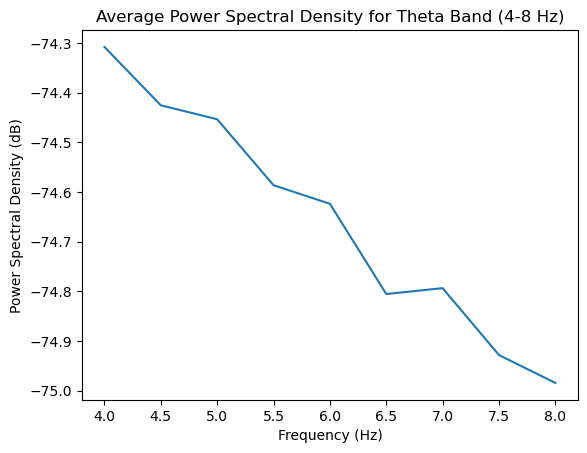

In [283]:
#Whole Brain

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in epochs.get_data():
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# psds is in shape (n_epochs, n_channels, n_freqs)
print(f"PSDs shape: {psds.shape}")
print(f"Frequencies shape: {freqs.shape}")

# Define theta band
theta_min, theta_max = 4, 8

# Find indices for theta band
theta_indices = np.where((freqs >= theta_min) & (freqs <= theta_max))[0]

# Extract theta band data
theta_psds = psds[:, :, theta_indices]
theta_freqs = freqs[theta_indices]

# Average theta PSD across epochs and channels for a more comprehensive view
theta_psd_mean = theta_psds.mean(axis=(0, 1))

# Plotting the average theta PSD
plt.plot(theta_freqs, 10 * np.log10(theta_psd_mean))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('Average Power Spectral Density for Theta Band (4-8 Hz)')
plt.show()

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_23942/2189179023.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  for epoch in epochs.get_data():


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

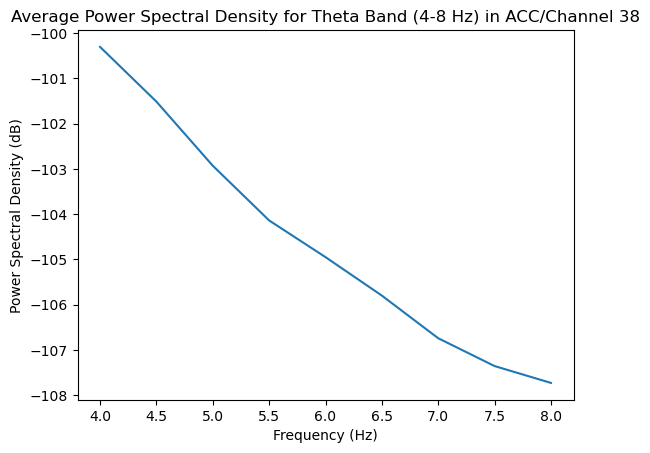

In [313]:
#ANTERIOR CINGULATE CORTEX

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in epochs.get_data():
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# psds is in shape (n_epochs, n_channels, n_freqs)
print(f"PSDs shape: {psds.shape}")
print(f"Frequencies shape: {freqs.shape}")

specific_channel = 38

# Define theta band
theta_min, theta_max = 4, 8

# Find indices for theta band
theta_indices = np.where((freqs >= theta_min) & (freqs <= theta_max))[0]

# Extract theta band data
theta_psds = psds[:, specific_channel, theta_indices]
theta_freqs = freqs[theta_indices]

# Average theta PSD across epochs and channels for a more comprehensive view
theta_psd_mean = theta_psds.mean(axis=0)

# Plotting the average theta PSD
plt.plot(theta_freqs, 10 * np.log10(theta_psd_mean))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('Average Power Spectral Density for Theta Band (4-8 Hz) in ACC/Channel {}'.format(specific_channel))
plt.show()

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_23942/1925333089.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  for epoch in epochs.get_data():


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

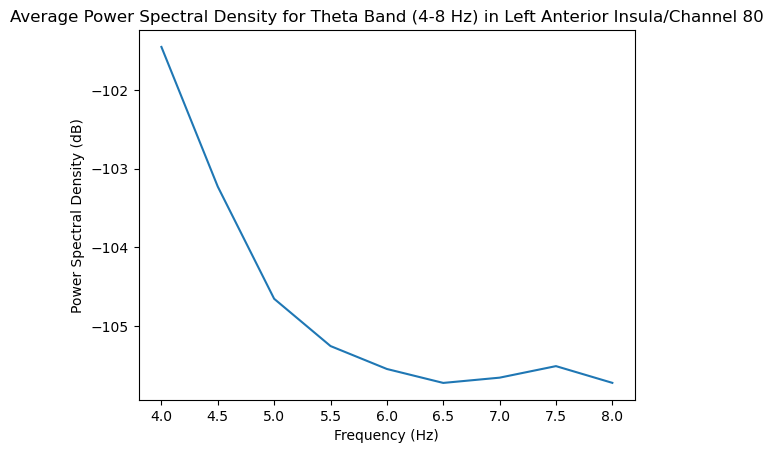

In [314]:
#ANTERIOR INSULA_L

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in epochs.get_data():
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# psds is in shape (n_epochs, n_channels, n_freqs)
print(f"PSDs shape: {psds.shape}")
print(f"Frequencies shape: {freqs.shape}")

specific_channel = 80

# Define theta band
theta_min, theta_max = 4, 8

# Find indices for theta band
theta_indices = np.where((freqs >= theta_min) & (freqs <= theta_max))[0]

# Extract theta band data
theta_psds = psds[:, specific_channel, theta_indices]
theta_freqs = freqs[theta_indices]

# Average theta PSD across epochs and channels for a more comprehensive view
theta_psd_mean = theta_psds.mean(axis=0)

# Plotting the average theta PSD
plt.plot(theta_freqs, 10 * np.log10(theta_psd_mean))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('Average Power Spectral Density for Theta Band (4-8 Hz) in Left Anterior Insula/Channel {}'.format(specific_channel))
plt.show()

- Congruent

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_23942/3993452284.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_congruent = epochs_congruent.get_data()


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

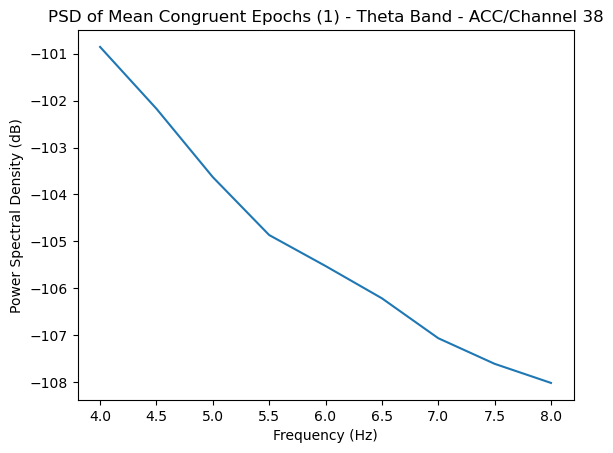

In [284]:
#ANTERIOR CINGULATE CORTEX

# Extract data from epochs
data_congruent = epochs_congruent.get_data()

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in data_congruent:
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# Specify the channel you want to analyze
specific_channel = 38  # Change this to the index of the channel you want to analyze

# Define theta band
theta_min, theta_max = 4, 8

# Find indices for theta band
theta_indices = np.where((freqs >= theta_min) & (freqs <= theta_max))[0]

# Extract theta band data
theta_congruent = psds[:, specific_channel, theta_indices].mean(axis=0)
theta_freqs = freqs[theta_indices]

# Plot the PSD for the theta band
plt.plot(theta_freqs, 10 * np.log10(theta_congruent))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD of Mean Congruent Epochs (1) - Theta Band - ACC/Channel {}'.format(specific_channel))
plt.show()

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_23942/3598157350.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_congruent = epochs_congruent.get_data()


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

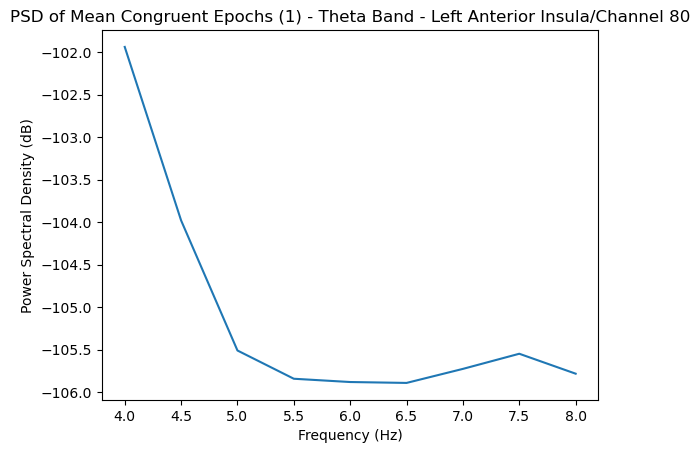

In [285]:
#ANTERIOR INSULA_L

# Extract data from epochs
data_congruent = epochs_congruent.get_data()

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in data_congruent:
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# Specify the channel you want to analyze
specific_channel = 80  # Change this to the index of the channel you want to analyze

# Define theta band
theta_min, theta_max = 4, 8

# Find indices for theta band
theta_indices = np.where((freqs >= theta_min) & (freqs <= theta_max))[0]

# Extract theta band data
theta_congruent = psds[:, specific_channel, theta_indices].mean(axis=0)
theta_freqs = freqs[theta_indices]

# Plot the PSD for the theta band
plt.plot(theta_freqs, 10 * np.log10(theta_congruent))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD of Mean Congruent Epochs (1) - Theta Band - Left Anterior Insula/Channel {}'.format(specific_channel))
plt.show()

- Incongruent

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)


/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_23942/1870274937.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_incongruent = epochs_incongruent.get_data()


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

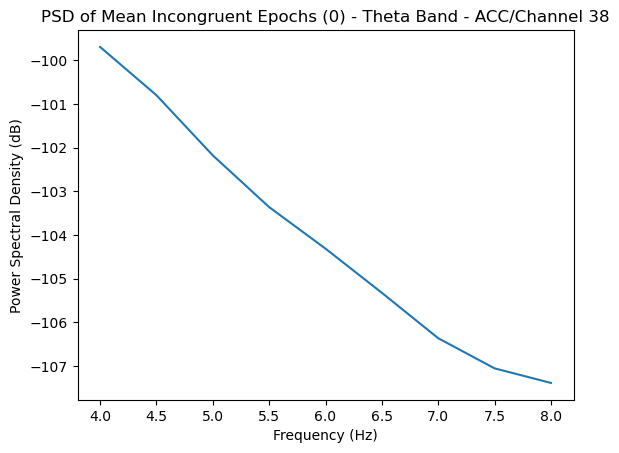

In [286]:
#ANTERIOR CINGULATE CORTEX

# Extract data from epochs
data_incongruent = epochs_incongruent.get_data()

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in data_incongruent:
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# Specify the channel you want to analyze
specific_channel = 38  # Change this to the index of the channel you want to analyze

# Define theta band
theta_min, theta_max = 4, 8

# Find indices for theta band
theta_indices = np.where((freqs >= theta_min) & (freqs <= theta_max))[0]

# Extract theta band data
theta_incongruent = psds[:, specific_channel, theta_indices].mean(axis=0)
theta_freqs = freqs[theta_indices]

# Plot the PSD for the theta band
plt.plot(theta_freqs, 10 * np.log10(theta_incongruent))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD of Mean Incongruent Epochs (0) - Theta Band - ACC/Channel {}'.format(specific_channel))
plt.show()

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_23942/2483683260.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_incongruent = epochs_incongruent.get_data()


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

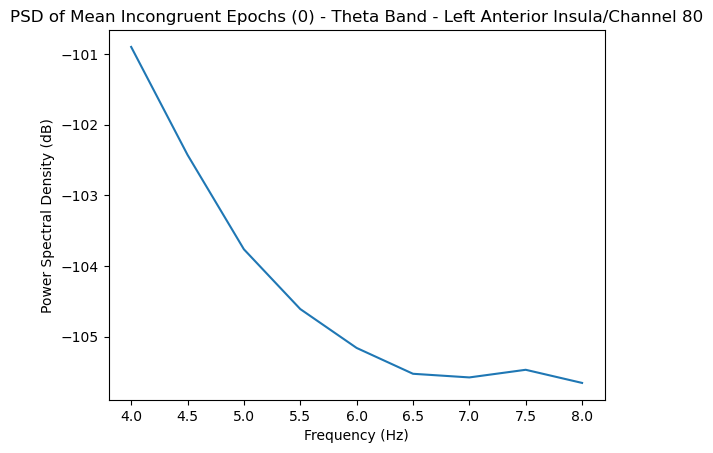

In [287]:
#ANTERIOR INSULA_L

# Extract data from epochs
data_incongruent = epochs_incongruent.get_data()

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in data_incongruent:
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# Specify the channel you want to analyze
specific_channel = 80  # Change this to the index of the channel you want to analyze

# Define theta band
theta_min, theta_max = 4, 8

# Find indices for theta band
theta_indices = np.where((freqs >= theta_min) & (freqs <= theta_max))[0]

# Extract theta band data
theta_incongruent = psds[:, specific_channel, theta_indices].mean(axis=0)
theta_freqs = freqs[theta_indices]

# Plot the PSD for the theta band
plt.plot(theta_freqs, 10 * np.log10(theta_incongruent))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD of Mean Incongruent Epochs (0) - Theta Band - Left Anterior Insula/Channel {}'.format(specific_channel))
plt.show()

Alpha Band

- All Trials

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_23942/205836842.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  for epoch in epochs.get_data():


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

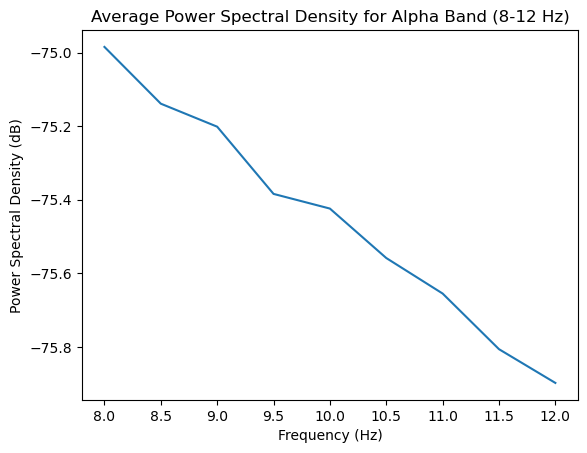

In [288]:
#Whole Brain

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in epochs.get_data():
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=50, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# psds is in shape (n_epochs, n_channels, n_freqs)
print(f"PSDs shape: {psds.shape}")
print(f"Frequencies shape: {freqs.shape}")

# Define alpha band
alpha_min, alpha_max = 8, 12

# Find indices for alpha band
alpha_indices = np.where((freqs >= alpha_min) & (freqs <= alpha_max))[0]

# Extract alpha band data
alpha_psds = psds[:, :, alpha_indices]
alpha_freqs = freqs[alpha_indices]

# Average alpha PSD across epochs and channels for a more comprehensive view
alpha_psd_mean = alpha_psds.mean(axis=(0, 1))

# Plotting the average alpha PSD
plt.plot(alpha_freqs, 10 * np.log10(alpha_psd_mean))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('Average Power Spectral Density for Alpha Band (8-12 Hz)')
plt.show()

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_23942/1493655201.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  for epoch in epochs.get_data():


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

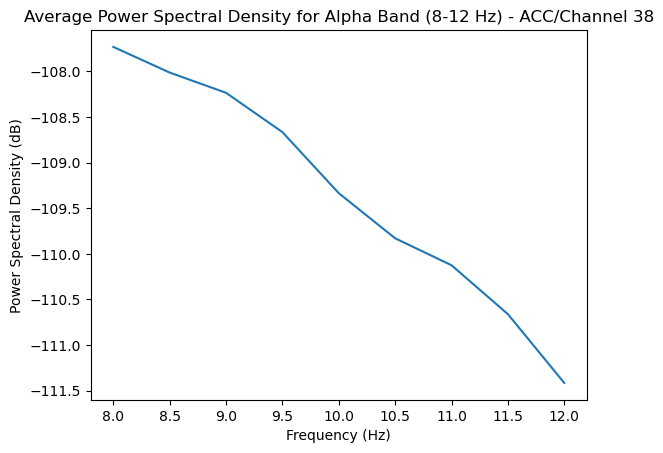

In [289]:
#ANTERIOR CINGULATE CORTEX

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in epochs.get_data():
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# psds is in shape (n_epochs, n_channels, n_freqs)
print(f"PSDs shape: {psds.shape}")
print(f"Frequencies shape: {freqs.shape}")


# Specify the channel you want to analyze
specific_channel = 38  # Change this to the brain area you want to analyze

# Define alpha band
alpha_min, alpha_max = 8, 12

# Find indices for alpha band
alpha_indices = np.where((freqs >= alpha_min) & (freqs <= alpha_max))[0]

# Extract alpha band data
alpha_psds = psds[:, specific_channel, alpha_indices]
alpha_freqs = freqs[alpha_indices]

# Average alpha PSD across epochs and channels for a more comprehensive view
alpha_psd_mean = alpha_psds.mean(axis=0)

# Plotting the average alpha PSD
plt.plot(alpha_freqs, 10 * np.log10(alpha_psd_mean))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('Average Power Spectral Density for Alpha Band (8-12 Hz) - ACC/Channel {}'.format(specific_channel))
plt.show()

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_23942/997888531.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  for epoch in epochs.get_data():


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

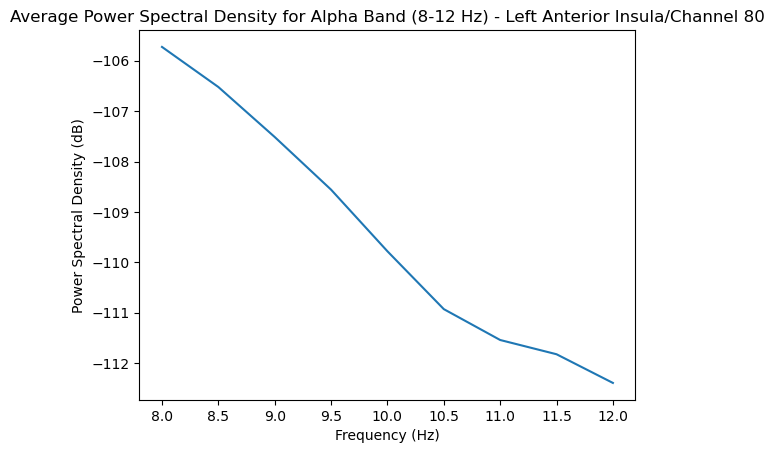

In [290]:
#ANTERIOR INSULA_L

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in epochs.get_data():
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# psds is in shape (n_epochs, n_channels, n_freqs)
print(f"PSDs shape: {psds.shape}")
print(f"Frequencies shape: {freqs.shape}")


# Specify the channel you want to analyze
specific_channel = 80  # Change this to the brain area you want to analyze

# Define alpha band
alpha_min, alpha_max = 8, 12

# Find indices for alpha band
alpha_indices = np.where((freqs >= alpha_min) & (freqs <= alpha_max))[0]

# Extract alpha band data
alpha_psds = psds[:, specific_channel, alpha_indices]
alpha_freqs = freqs[alpha_indices]

# Average alpha PSD across epochs and channels for a more comprehensive view
alpha_psd_mean = alpha_psds.mean(axis=0)

# Plotting the average alpha PSD
plt.plot(alpha_freqs, 10 * np.log10(alpha_psd_mean))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('Average Power Spectral Density for Alpha Band (8-12 Hz) - Left Anterior Insula/Channel {}'.format(specific_channel))
plt.show()

- Congruent

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)


/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_23942/4079076699.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_congruent = epochs_congruent.get_data()


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

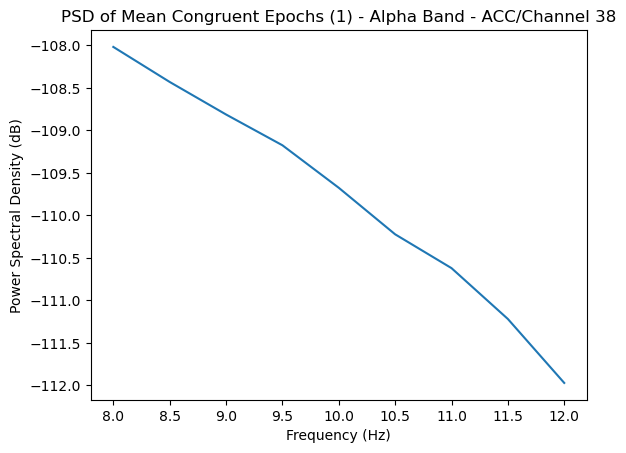

In [291]:
#ANTERIOR CINGULATE CORTEX

# Extract data from epochs
data_congruent = epochs_congruent.get_data()

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in data_congruent:
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# Specify the channel you want to analyze
specific_channel = 38  # Change this to the index of the channel you want to analyze

# Define alpha band
alpha_min, alpha_max = 8, 12

# Find indices for alpha band
alpha_indices = np.where((freqs >= alpha_min) & (freqs <= alpha_max))[0]

# Compute the mean of all congruent epochs for the specified channel
alpha_congruent = psds[:, specific_channel, alpha_indices].mean(axis=0)
alpha_freqs = freqs[alpha_indices]


# Plot the PSD for the theta band
plt.plot(alpha_freqs, 10 * np.log10(alpha_congruent))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD of Mean Congruent Epochs (1) - Alpha Band - ACC/Channel {}'.format(specific_channel))
plt.show()

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_23942/1293274948.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_congruent = epochs_congruent.get_data()


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

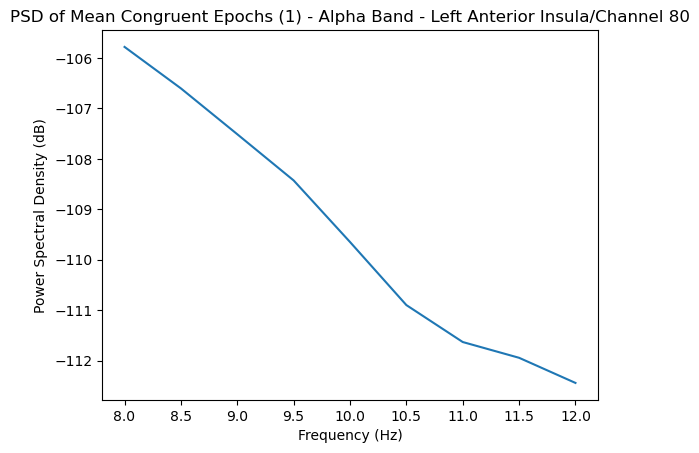

In [309]:
#ANTERIOR INSULA_L

# Extract data from epochs
data_congruent = epochs_congruent.get_data()

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in data_congruent:
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# Specify the channel you want to analyze
specific_channel = 80  # Change this to the index of the channel you want to analyze

# Define alpha band
alpha_min, alpha_max = 8, 12

# Find indices for alpha band
alpha_indices = np.where((freqs >= alpha_min) & (freqs <= alpha_max))[0]

# Compute the mean of all congruent epochs for the specified channel
alpha_congruent = psds[:, specific_channel, alpha_indices].mean(axis=0)
alpha_freqs = freqs[alpha_indices]


# Plot the PSD for the theta band
plt.plot(alpha_freqs, 10 * np.log10(alpha_congruent))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD of Mean Congruent Epochs (1) - Alpha Band - Left Anterior Insula/Channel {}'.format(specific_channel))
plt.show()

- Incongruent

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_23942/3136291986.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_incongruent = epochs_incongruent.get_data()


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

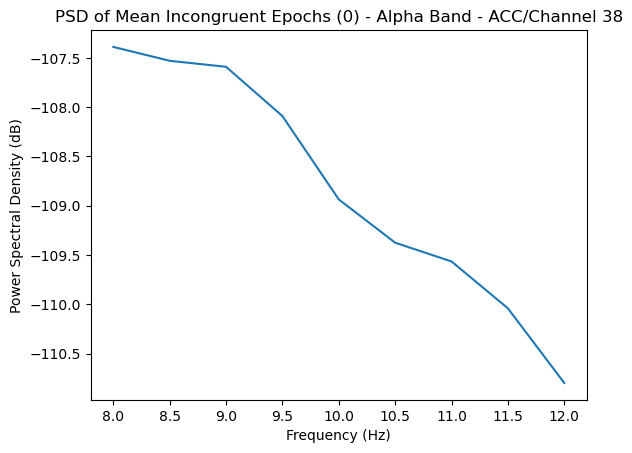

In [292]:
#ANTERIOR CINGULATE CORTEX

# Extract data from epochs
data_incongruent = epochs_incongruent.get_data()

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in data_incongruent:
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# Specify the channel you want to analyze
specific_channel = 38  # Change this to the index of the channel you want to analyze

# Define alpha band
alpha_min, alpha_max = 8, 12

# Find indices for alpha band
alpha_indices = np.where((freqs >= alpha_min) & (freqs <= alpha_max))[0]

# Compute the mean of all congruent epochs for the specified channel
alpha_incongruent = psds[:, specific_channel, alpha_indices].mean(axis=0)
alpha_freqs = freqs[alpha_indices]

# Average alpha PSD across epochs and channels for a more comprehensive view


# Plot the PSD for the general band
plt.plot(alpha_freqs, 10 * np.log10(alpha_incongruent))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD of Mean Incongruent Epochs (0) - Alpha Band - ACC/Channel {}'.format(specific_channel))
plt.show()

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)


/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_23942/1561841493.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_incongruent = epochs_incongruent.get_data()


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

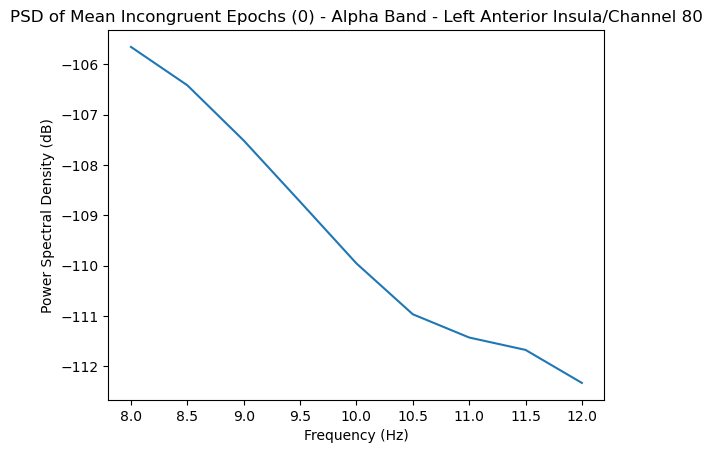

In [308]:
#ANTERIOR INSULA_L

# Extract data from epochs
data_incongruent = epochs_incongruent.get_data()

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in data_incongruent:
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# Specify the channel you want to analyze
specific_channel = 80  # Change this to the index of the channel you want to analyze

# Define alpha band
alpha_min, alpha_max = 8, 12

# Find indices for alpha band
alpha_indices = np.where((freqs >= alpha_min) & (freqs <= alpha_max))[0]

# Compute the mean of all congruent epochs for the specified channel
alpha_incongruent = psds[:, specific_channel, alpha_indices].mean(axis=0)
alpha_freqs = freqs[alpha_indices]

# Average alpha PSD across epochs and channels for a more comprehensive view


# Plot the PSD for the general band
plt.plot(alpha_freqs, 10 * np.log10(alpha_incongruent))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD of Mean Incongruent Epochs (0) - Alpha Band - Left Anterior Insula/Channel {}'.format(specific_channel))
plt.show()

Beta Band

- All Trials

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_23942/2020116292.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  for epoch in epochs.get_data():


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

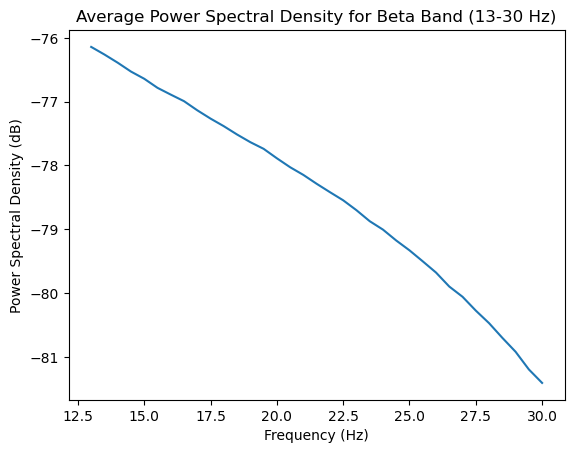

In [293]:
#Whole Brain

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in epochs.get_data():
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# psds is in shape (n_epochs, n_channels, n_freqs)
print(f"PSDs shape: {psds.shape}")
print(f"Frequencies shape: {freqs.shape}")

# Define beta band
beta_min, beta_max = 13, 30

# Find indices for beta band
beta_indices = np.where((freqs >= beta_min) & (freqs <= beta_max))[0]

# Extract beta band data
beta_psds = psds[:, :, beta_indices]
beta_freqs = freqs[beta_indices]

# Average beta PSD across epochs and channels for a more comprehensive view
beta_psd_mean = beta_psds.mean(axis=(0, 1))

# Plotting the average beta PSD
plt.plot(beta_freqs, 10 * np.log10(beta_psd_mean))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('Average Power Spectral Density for Beta Band (13-30 Hz)')
plt.show()

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_23942/3397094902.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  for epoch in epochs.get_data():


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

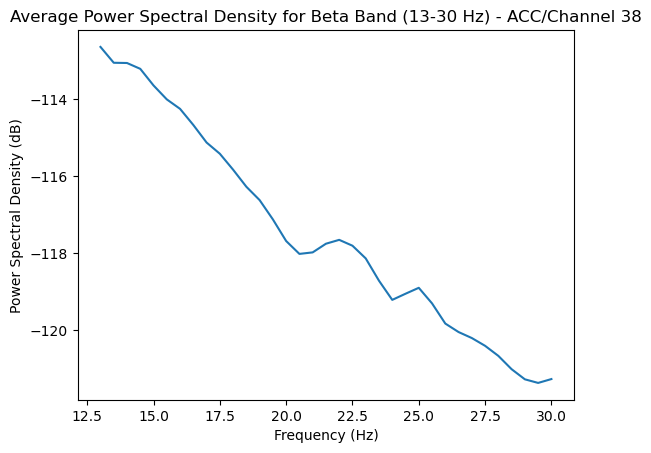

In [294]:
#ANTERIOR CINGULATE CORTEX

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in epochs.get_data():
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# psds is in shape (n_epochs, n_channels, n_freqs)
print(f"PSDs shape: {psds.shape}")
print(f"Frequencies shape: {freqs.shape}")

specific_channel = 38

# Define beta band
beta_min, beta_max = 13, 30

# Find indices for beta band
beta_indices = np.where((freqs >= beta_min) & (freqs <= beta_max))[0]

# Extract beta band data
beta_psds = psds[:, specific_channel, beta_indices]
beta_freqs = freqs[beta_indices]

# Average beta PSD across epochs and channels for a more comprehensive view
beta_psd_mean = beta_psds.mean(axis=0)

# Plotting the average beta PSD
plt.plot(beta_freqs, 10 * np.log10(beta_psd_mean))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('Average Power Spectral Density for Beta Band (13-30 Hz) - ACC/Channel {}'.format(specific_channel))
plt.show()

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_23942/4210163554.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  for epoch in epochs.get_data():


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

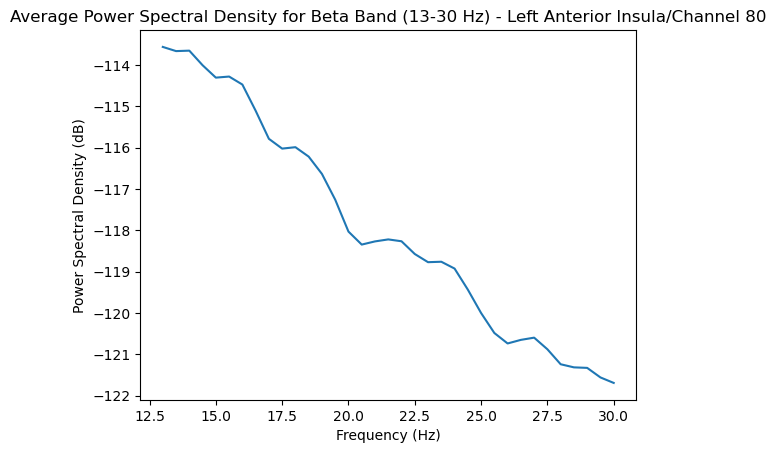

In [295]:
#ANTERIOR INSULA_L

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in epochs.get_data():
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# psds is in shape (n_epochs, n_channels, n_freqs)
print(f"PSDs shape: {psds.shape}")
print(f"Frequencies shape: {freqs.shape}")

specific_channel = 80

# Define beta band
beta_min, beta_max = 13, 30

# Find indices for beta band
beta_indices = np.where((freqs >= beta_min) & (freqs <= beta_max))[0]

# Extract beta band data
beta_psds = psds[:, specific_channel, beta_indices]
beta_freqs = freqs[beta_indices]

# Average beta PSD across epochs and channels for a more comprehensive view
beta_psd_mean = beta_psds.mean(axis=0)

# Plotting the average beta PSD
plt.plot(beta_freqs, 10 * np.log10(beta_psd_mean))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('Average Power Spectral Density for Beta Band (13-30 Hz) - Left Anterior Insula/Channel {}'.format(specific_channel))
plt.show()

- Congruent

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)


/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_23942/3596473712.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_congruent = epochs_congruent.get_data()


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

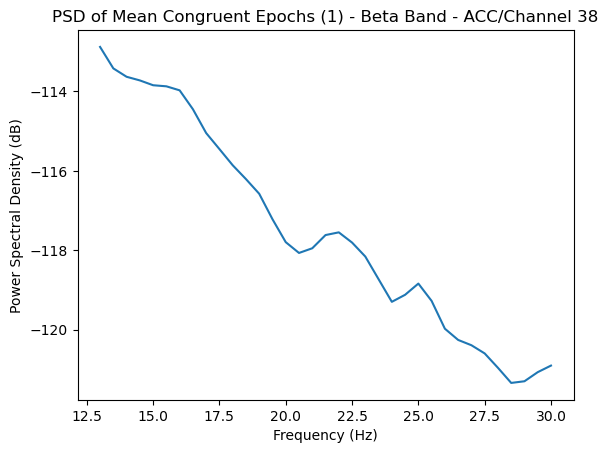

In [296]:
#ANTERIOR CINGULATE CORTEX

# Extract data from epochs
data_congruent = epochs_congruent.get_data()

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in data_congruent:
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# Specify the channel you want to analyze
specific_channel = 38  # Change this to the index of the channel you want to analyze

# Define beta band
beta_min, beta_max = 13, 30

# Find indices for beta band
beta_indices = np.where((freqs >= beta_min) & (freqs <= beta_max))[0]

# Compute the mean of all congruent epochs for the specified channel
beta_congruent = psds[:, specific_channel, beta_indices].mean(axis=0)
beta_freqs = freqs[beta_indices]


# Plot the PSD for the theta band
plt.plot(beta_freqs, 10 * np.log10(beta_congruent))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD of Mean Congruent Epochs (1) - Beta Band - ACC/Channel {}'.format(specific_channel))
plt.show()

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_23942/3350338386.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_congruent = epochs_congruent.get_data()


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

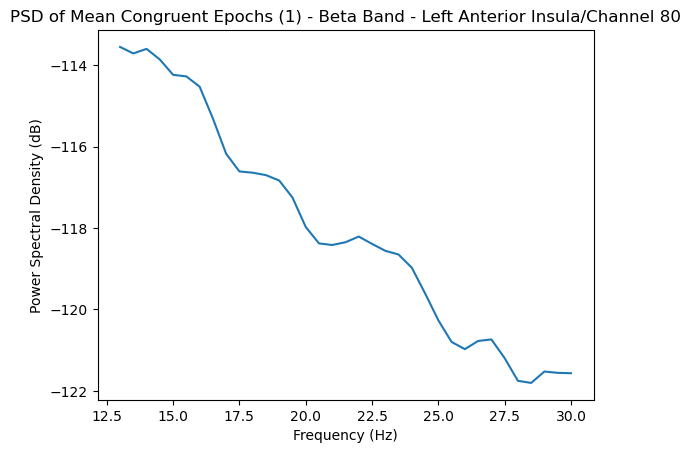

In [297]:
#ANTERIOR INSULA_L

# Extract data from epochs
data_congruent = epochs_congruent.get_data()

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in data_congruent:
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# Specify the channel you want to analyze
specific_channel = 80  # Change this to the index of the channel you want to analyze

# Define beta band
beta_min, beta_max = 13, 30

# Find indices for beta band
beta_indices = np.where((freqs >= beta_min) & (freqs <= beta_max))[0]

# Compute the mean of all congruent epochs for the specified channel
beta_congruent = psds[:, specific_channel, beta_indices].mean(axis=0)
beta_freqs = freqs[beta_indices]


# Plot the PSD for the theta band
plt.plot(beta_freqs, 10 * np.log10(beta_congruent))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD of Mean Congruent Epochs (1) - Beta Band - Left Anterior Insula/Channel {}'.format(specific_channel))
plt.show()

- Incongruent

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_23942/2767970973.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_incongruent = epochs_incongruent.get_data()


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

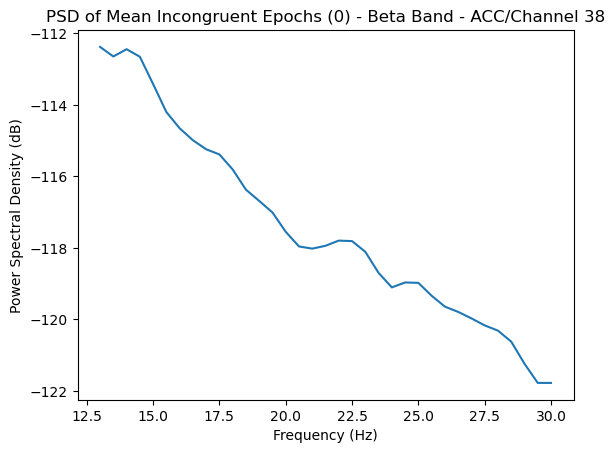

In [298]:
#ANTERIOR CINGULATE CORTEX

# Extract data from epochs
data_incongruent = epochs_incongruent.get_data()

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in data_incongruent:
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# Specify the channel you want to analyze
specific_channel = 38  # Change this to the index of the channel you want to analyze

# Define beta band
beta_min, beta_max = 13, 30

# Find indices for beta band
beta_indices = np.where((freqs >= beta_min) & (freqs <= beta_max))[0]

# Compute the mean of all congruent epochs for the specified channel
beta_incongruent = psds[:, specific_channel, beta_indices].mean(axis=0)
beta_freqs = freqs[beta_indices]


# Plot the PSD for the theta band
plt.plot(beta_freqs, 10 * np.log10(beta_incongruent))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD of Mean Incongruent Epochs (0) - Beta Band - ACC/Channel {}'.format(specific_channel))
plt.show()

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_23942/4150081458.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_incongruent = epochs_incongruent.get_data()


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

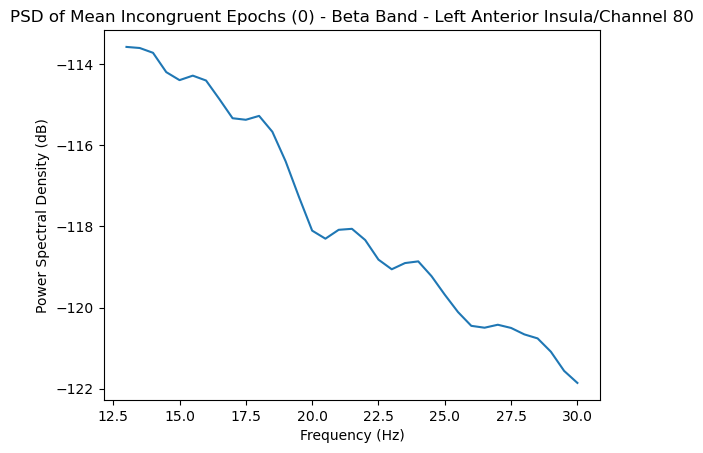

In [299]:
#ANTERIOR INSULA_L

# Extract data from epochs
data_incongruent = epochs_incongruent.get_data()

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in data_incongruent:
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# Specify the channel you want to analyze
specific_channel = 80  # Change this to the index of the channel you want to analyze

# Define beta band
beta_min, beta_max = 13, 30

# Find indices for beta band
beta_indices = np.where((freqs >= beta_min) & (freqs <= beta_max))[0]

# Compute the mean of all congruent epochs for the specified channel
beta_incongruent = psds[:, specific_channel, beta_indices].mean(axis=0)
beta_freqs = freqs[beta_indices]


# Plot the PSD for the theta band
plt.plot(beta_freqs, 10 * np.log10(beta_incongruent))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD of Mean Incongruent Epochs (0) - Beta Band - Left Anterior Insula/Channel {}'.format(specific_channel))
plt.show()

Gamma Band

- All Trials

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_23942/189582010.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  for epoch in epochs.get_data():


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

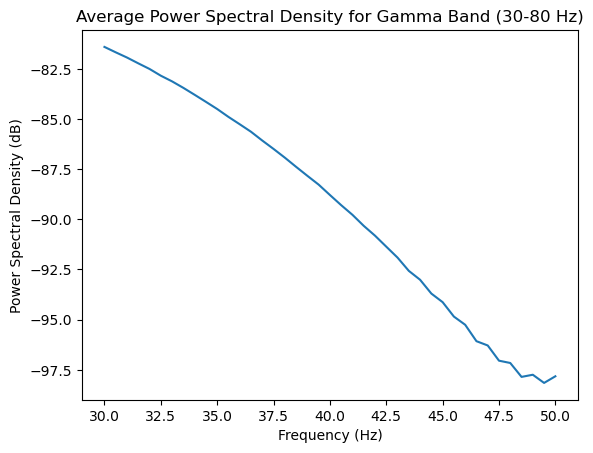

In [300]:
#Whole Brain

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in epochs.get_data():
    psd, freqs = mne.time_frequency.psd_array_welch(epoch, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# psds is in shape (n_epochs, n_channels, n_freqs)
print(f"PSDs shape: {psds.shape}")
print(f"Frequencies shape: {freqs.shape}")

# Define gamma band
gamma_min, gamma_max = 30, 80

# Find indices for gamma band
gamma_indices = np.where((freqs >= gamma_min) & (freqs <= gamma_max))[0]

# Extract gamma band data
gamma_psds = psds[:, :, gamma_indices]
gamma_freqs = freqs[gamma_indices]

# Average gamma PSD across epochs and channels for a more comprehensive view
gamma_psd_mean = gamma_psds.mean(axis=(0, 1))

# Plotting the average gamma PSD
plt.plot(gamma_freqs, 10 * np.log10(gamma_psd_mean))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('Average Power Spectral Density for Gamma Band (30-80 Hz)')
plt.show()

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- H

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:9: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  for epoch in epochs.get_data():
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Paralle

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the 

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the 

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- H

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the 

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the 

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the 

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the 

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the 

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pas

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the 

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the 

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- H

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the 

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the 

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the 

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the 

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the 

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
/var/folders/_9/

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the 

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/

- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, no

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the 

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the 

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- H

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the 

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/

- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, no

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the 

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the 

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the 

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- H

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the 

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the 

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the 

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the 

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the 

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the 

Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation


/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the 

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the 

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the 

Effective window size : 2.000 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_1199/2689446178.py:10: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))


Effective window size : 2.000 (s)
PSDs shape: (319, 148, 161)
Frequencies shape: (161,)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s


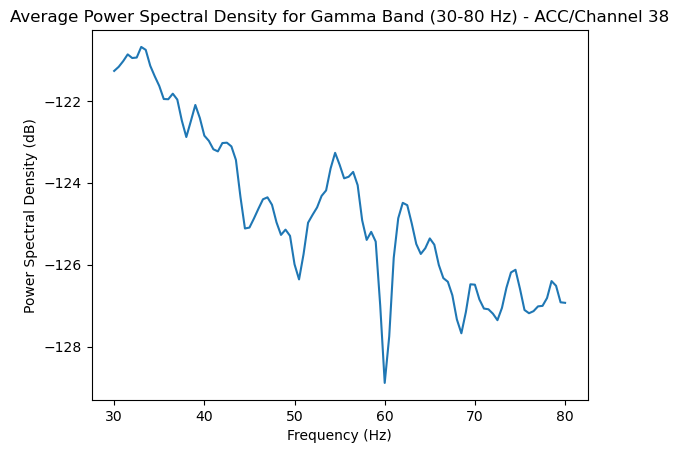

In [34]:
#ANTERIOR CINGULATE CORTEX

# Initialize an empty list to store PSDs
psds_list = []

sfreq = epochs_congruent.info['sfreq']

# Compute PSD for each epoch
for epoch in epochs.get_data():
    filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
    psd, freqs = mne.time_frequency.psd_array_welch(filtered_data, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# psds is in shape (n_epochs, n_channels, n_freqs)
print(f"PSDs shape: {psds.shape}")
print(f"Frequencies shape: {freqs.shape}")

specific_channel = 38

# Define gamma band
gamma_min, gamma_max = 30, 80

# Find indices for gamma band
gamma_indices = np.where((freqs >= gamma_min) & (freqs <= gamma_max))[0]

# Extract gamma band data
gamma_psds = psds[:, specific_channel, gamma_indices]
gamma_freqs = freqs[gamma_indices]

# Average gamma PSD across epochs and channels for a more comprehensive view
gamma_psd_mean = gamma_psds.mean(axis=0)

# Plotting the average gamma PSD
plt.plot(gamma_freqs, 10 * np.log10(gamma_psd_mean))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('Average Power Spectral Density for Gamma Band (30-80 Hz) - ACC/Channel {}'.format(specific_channel))
plt.show()

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_23942/1838640440.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  for epoch in epochs.get_data():


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

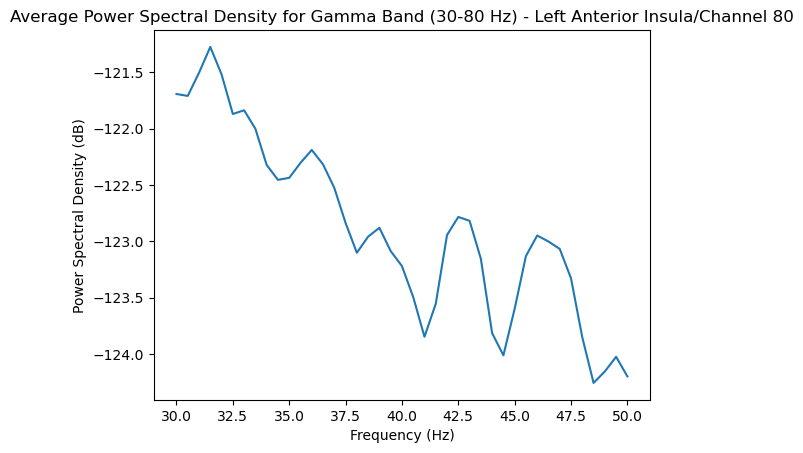

In [302]:
#ANTERIOR INSULA_L

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in epochs.get_data():
    filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
    psd, freqs = mne.time_frequency.psd_array_welch(filtered_data, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# psds is in shape (n_epochs, n_channels, n_freqs)
print(f"PSDs shape: {psds.shape}")
print(f"Frequencies shape: {freqs.shape}")

specific_channel = 80

# Define gamma band
gamma_min, gamma_max = 30, 80

# Find indices for gamma band
gamma_indices = np.where((freqs >= gamma_min) & (freqs <= gamma_max))[0]

# Extract gamma band data
gamma_psds = psds[:, specific_channel, gamma_indices]
gamma_freqs = freqs[gamma_indices]

# Average gamma PSD across epochs and channels for a more comprehensive view
gamma_psd_mean = gamma_psds.mean(axis=0)

# Plotting the average gamma PSD
plt.plot(gamma_freqs, 10 * np.log10(gamma_psd_mean))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('Average Power Spectral Density for Gamma Band (30-80 Hz) - Left Anterior Insula/Channel {}'.format(specific_channel))
plt.show()

- Congruent

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_23942/2323353798.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_congruent = epochs_congruent.get_data()


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

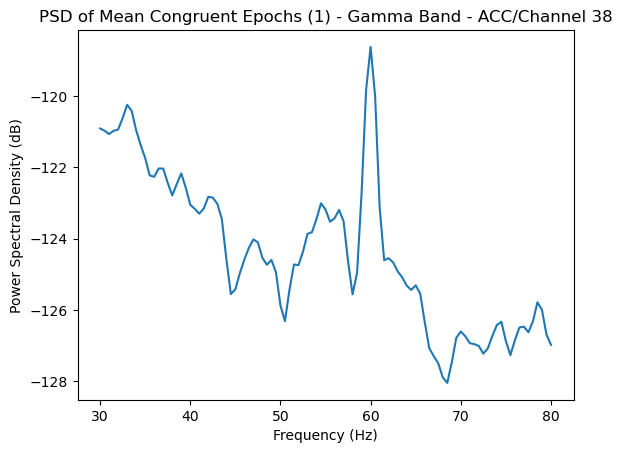

In [303]:
#ANTERIOR CINGULATE CORTEX

# Extract data from epochs
data_congruent = epochs_congruent.get_data()

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in data_congruent:
    filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
    psd, freqs = mne.time_frequency.psd_array_welch(filtered_data, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# Specify the channel you want to analyze
specific_channel = 38  # Change this to the index of the channel you want to analyze

# Define gamma band
gamma_min, gamma_max = 30, 80

# Find indices for gamma band
gamma_indices = np.where((freqs >= gamma_min) & (freqs <= gamma_max))[0]

# Compute the mean of all congruent epochs for the specified channel
gamma_congruent = psds[:, specific_channel, gamma_indices].mean(axis=0)
gamma_freqs = freqs[gamma_indices]


# Plot the PSD for the theta band
plt.plot(gamma_freqs, 10 * np.log10(gamma_congruent))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD of Congruent Trials - Gamma Band - Anterior Cingulate Cortex')
plt.show()

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_23942/614890904.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_congruent = epochs_congruent.get_data()


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

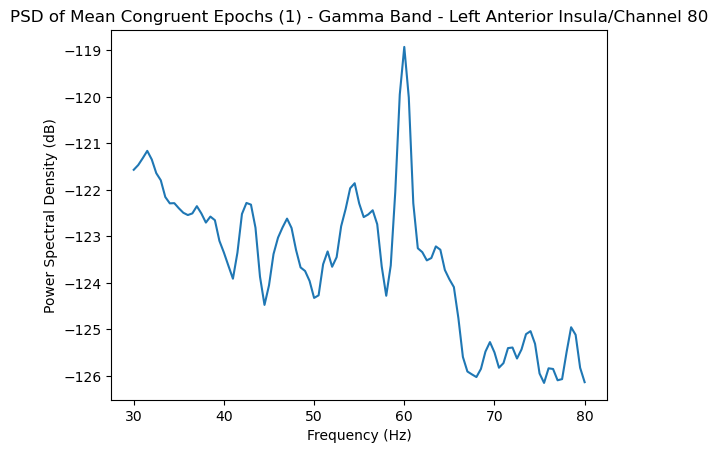

In [304]:
#ANTERIOR INSULA_L

# Extract data from epochs
data_congruent = epochs_congruent.get_data()

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in data_congruent:
    filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
    psd, freqs = mne.time_frequency.psd_array_welch(filtered_data, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# Specify the channel you want to analyze
specific_channel = 80  # Change this to the index of the channel you want to analyze

# Define gamma band
gamma_min, gamma_max = 30, 80

# Find indices for gamma band
gamma_indices = np.where((freqs >= gamma_min) & (freqs <= gamma_max))[0]

# Compute the mean of all congruent epochs for the specified channel
gamma_congruent = psds[:, specific_channel, gamma_indices].mean(axis=0)
gamma_freqs = freqs[gamma_indices]


# Plot the PSD for the theta band
plt.plot(gamma_freqs, 10 * np.log10(gamma_congruent))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD of Congruent Trials - Gamma Band - Left Anterior Insula')
plt.show()

- Incongruent

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)


/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_23942/203897559.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_incongruent = epochs_incongruent.get_data()


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

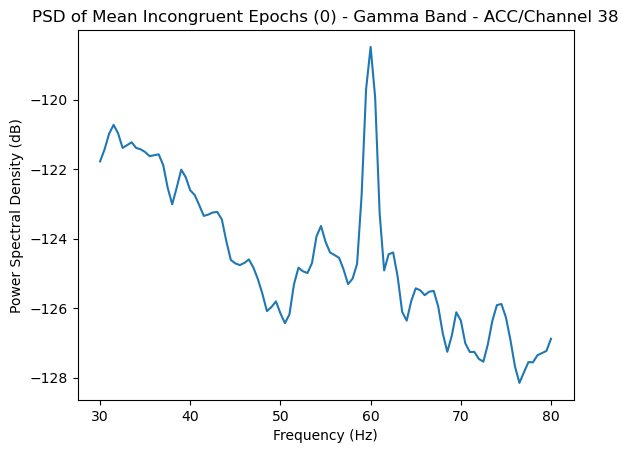

In [305]:
#ANTERIOR CINGULATE CORTEX

# Extract data from epochs
data_incongruent = epochs_incongruent.get_data()

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in data_incongruent:
    filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
    psd, freqs = mne.time_frequency.psd_array_welch(filtered_data, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# Specify the channel you want to analyze
specific_channel = 38  # Change this to the index of the channel you want to analyze

# Define gamma band
gamma_min, gamma_max = 30, 80

# Find indices for gamma band
gamma_indices = np.where((freqs >= gamma_min) & (freqs <= gamma_max))[0]

# Compute the mean of all congruent epochs for the specified channel
gamma_incongruent = psds[:, specific_channel, gamma_indices].mean(axis=0)
gamma_freqs = freqs[gamma_indices]


# Plot the PSD for the theta band
plt.plot(gamma_freqs, 10 * np.log10(gamma_incongruent))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD of Incongruent Trials - Gamma Band - Anterior Cingulate Cortex')
plt.show()

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_23942/276872065.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_incongruent = epochs_incongruent.get_data()


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective wind

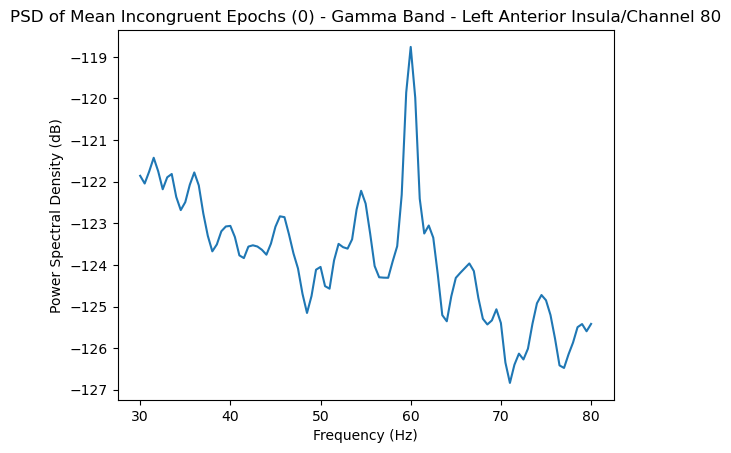

In [306]:
#ANTERIOR INSULA_L

# Extract data from epochs
data_incongruent = epochs_incongruent.get_data()

# Initialize an empty list to store PSDs
psds_list = []

# Compute PSD for each epoch
for epoch in data_incongruent:
    filtered_data = mne.filter.notch_filter(epoch, sfreq, freqs=np.arange(60, 241, 60))
    psd, freqs = mne.time_frequency.psd_array_welch(filtered_data, sfreq=1024, fmin=0, fmax=80, n_fft=2048, n_per_seg=1024)
    psds_list.append(psd)

# Convert list of PSDs to a numpy array
psds = np.array(psds_list)

# Specify the channel you want to analyze
specific_channel = 80  # Change this to the index of the channel you want to analyze

# Define gamma band
gamma_min, gamma_max = 30, 80

# Find indices for gamma band
gamma_indices = np.where((freqs >= gamma_min) & (freqs <= gamma_max))[0]

# Compute the mean of all congruent epochs for the specified channel
gamma_incongruent = psds[:, specific_channel, gamma_indices].mean(axis=0)
gamma_freqs = freqs[gamma_indices]


# Plot the PSD for the theta band
plt.plot(gamma_freqs, 10 * np.log10(gamma_incongruent))  # Convert to dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD of Mean Incongruent Trials - Gamma Band - Left Anterior Insula')
plt.show()

# Phase Amplitude Coupling

Congruent Trials

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/2870714826.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_congruent = epochs_congruent.get_data()
Phase Amplitude Coupling object defined


Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Setting up band-pass filter from 30 - 80 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 30.00, 80.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a o

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/2870714826.py:25: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  theta_data = mne.filter.notch_filter(phase_data, sfreq, freqs = np.arange(60, 241, 60))
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/2870714826.py:35: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  gamma_data = mne.filter.notch_filter(amplitude_data, sfreq, freqs = np.arange(60, 241, 60))
    extract phases (n_pha=4) and amplitudes (n_amps=45)
    true PAC estimation using Gaussian Copula PAC (gcPac)
WARNING | 3d pac array has been given as an input. Only 2d arrays are supported for plotting. Taking the mean across the last dimension


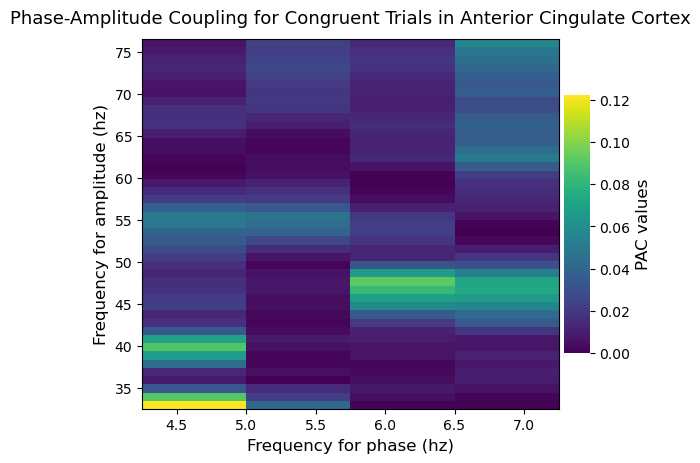

In [73]:
#ANTERIOR CINGULATE CORTEX

# data_congruent should be the data array from epochs_congruent
data_congruent = epochs_congruent.get_data()

# Adjust the PAC object parameters
p = Pac(idpac=(6, 0, 0), f_pha=(4, 8, 0.5, 1), f_amp=(30, 80, 5, 1), dcomplex='hilbert', cycle=(3, 6), width=7)

# Specify the epoch and channel you want to analyze
specific_channel = 38  # Change this to the index of the channel you want to analyze
theta_min, theta_max = 4, 8  # Define the theta band
gamma_min, gamma_max = 30, 80  # Define the theta band

# Get the sampling frequency
sfreq = epochs_congruent.info['sfreq']

# Extract phase and amplitude data
phase_data = data_congruent[:, specific_channel, :].mean(axis=0)  # Extract the phase data (e.g., 4-8 Hz)
amplitude_data = data_congruent[:, specific_channel, :].mean(axis=0)  # Extract the amplitude data (e.g., 80-120 Hz)

#PHASE
# Filter the data in the theta band
theta_data = mne.filter.filter_data(phase_data, sfreq, theta_min, theta_max, method='iir')
#Notch Filter at 60 Hz
theta_data = mne.filter.notch_filter(phase_data, sfreq, freqs = np.arange(60, 241, 60))
# Compute the Hilbert transform to get the analytic signal
analytic_signal = hilbert(theta_data, axis=-1)
# Extract the phase of the analytic signal
data_phase = np.angle(analytic_signal)

#AMPLITUDE
# Filter the data in the theta band
gamma_data = mne.filter.filter_data(amplitude_data, sfreq, gamma_min, gamma_max, method='iir')
#Notch Filter at 60 Hz
gamma_data = mne.filter.notch_filter(amplitude_data, sfreq, freqs = np.arange(60, 241, 60))
# Compute the Hilbert transform to get the analytic signal
analytic_signal = hilbert(gamma_data, axis=-1)
# Extract the phase of the analytic signal
data_amplitude = np.angle(analytic_signal)

# Compute PAC
pac = p.filterfit(epochs.info['sfreq'], data_phase, data_amplitude)

# Plot the PAC
p.comodulogram(pac, title='Phase-Amplitude Coupling for Congruent Trials in Anterior Cingulate Cortex')
plt.show()

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/2720576006.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_congruent = epochs_congruent.get_data()
Phase Amplitude Coupling object defined


Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Setting up band-pass filter from 30 - 80 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 30.00, 80.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a o

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/2720576006.py:25: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  theta_data = mne.filter.notch_filter(phase_data, sfreq, freqs = np.arange(60, 241, 60))
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/2720576006.py:35: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  gamma_data = mne.filter.notch_filter(amplitude_data, sfreq, freqs = np.arange(60, 241, 60))
    extract phases (n_pha=4) and amplitudes (n_amps=45)
    true PAC estimation using Gaussian Copula PAC (gcPac)
WARNING | 3d pac array has been given as an input. Only 2d arrays are supported for plotting. Taking the mean across the last dimension


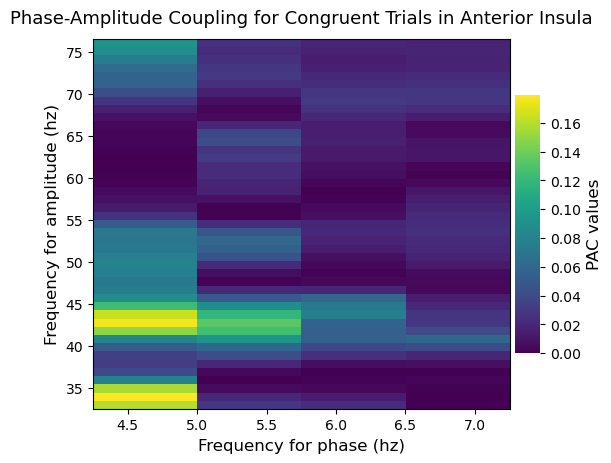

In [74]:
#ANTERIOR INSULA

# data_congruent should be the data array from epochs_congruent
data_congruent = epochs_congruent.get_data()

# Adjust the PAC object parameters
p = Pac(idpac=(6, 0, 0), f_pha=(4, 8, 0.5, 1), f_amp=(30, 80, 5, 1), dcomplex='hilbert', cycle=(3, 6), width=7)

# Specify the epoch and channel you want to analyze
specific_channel = 80  # Change this to the index of the channel you want to analyze
theta_min, theta_max = 4, 8  # Define the theta band
gamma_min, gamma_max = 30, 80  # Define the theta band

# Get the sampling frequency
sfreq = epochs_congruent.info['sfreq']

# Extract phase and amplitude data
phase_data = data_congruent[:, specific_channel, :].mean(axis=0)  # Extract the phase data (e.g., 4-8 Hz)
amplitude_data = data_congruent[:, specific_channel, :].mean(axis=0)  # Extract the amplitude data (e.g., 80-120 Hz)

#PHASE
# Filter the data in the theta band
theta_data = mne.filter.filter_data(phase_data, sfreq, theta_min, theta_max, method='iir')
#Notch Filter at 60 Hz
theta_data = mne.filter.notch_filter(phase_data, sfreq, freqs = np.arange(60, 241, 60))
# Compute the Hilbert transform to get the analytic signal
analytic_signal = hilbert(theta_data, axis=-1)
# Extract the phase of the analytic signal
data_phase = np.angle(analytic_signal)

#AMPLITUDE
# Filter the data in the theta band
gamma_data = mne.filter.filter_data(amplitude_data, sfreq, gamma_min, gamma_max, method='iir')
#Notch Filter at 60 Hz
gamma_data = mne.filter.notch_filter(amplitude_data, sfreq, freqs = np.arange(60, 241, 60))
# Compute the Hilbert transform to get the analytic signal
analytic_signal = hilbert(gamma_data, axis=-1)
# Extract the phase of the analytic signal
data_amplitude = np.angle(analytic_signal)

# Compute PAC
pac = p.filterfit(epochs.info['sfreq'], data_phase, data_amplitude)

# Plot the PAC
p.comodulogram(pac, title='Phase-Amplitude Coupling for Congruent Trials in Anterior Insula')
plt.show()

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/2657999807.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_congruent = epochs_congruent.get_data()
Phase Amplitude Coupling object defined


Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Setting up band-pass filter from 30 - 80 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 30.00, 80.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a o

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/2657999807.py:25: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  theta_data = mne.filter.notch_filter(phase_data, sfreq, freqs = np.arange(60, 241, 60))
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/2657999807.py:35: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  gamma_data = mne.filter.notch_filter(amplitude_data, sfreq, freqs = np.arange(60, 241, 60))
    extract phases (n_pha=4) and amplitudes (n_amps=45)
    true PAC estimation using Gaussian Copula PAC (gcPac)
WARNING | 3d pac array has been given as an input. Only 2d arrays are supported for plotting. Taking the mean across the last dimension


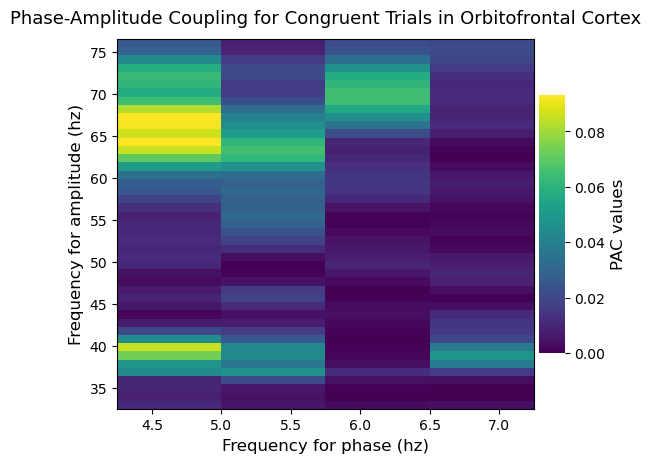

In [75]:
#ORBITOFRONTAL CORTEX

# data_congruent should be the data array from epochs_congruent
data_congruent = epochs_congruent.get_data()

# Adjust the PAC object parameters
p = Pac(idpac=(6, 0, 0), f_pha=(4, 8, 0.5, 1), f_amp=(30, 80, 5, 1), dcomplex='hilbert', cycle=(3, 6), width=7)

# Specify the epoch and channel you want to analyze
specific_channel = 61  # Change this to the index of the channel you want to analyze
theta_min, theta_max = 4, 8  # Define the theta band
gamma_min, gamma_max = 30, 80  # Define the theta band

# Get the sampling frequency
sfreq = epochs_congruent.info['sfreq']

# Extract phase and amplitude data
phase_data = data_congruent[:, specific_channel, :].mean(axis=0)  # Extract the phase data (e.g., 4-8 Hz)
amplitude_data = data_congruent[:, specific_channel, :].mean(axis=0)  # Extract the amplitude data (e.g., 80-120 Hz)

#PHASE
# Filter the data in the theta band
theta_data = mne.filter.filter_data(phase_data, sfreq, theta_min, theta_max, method='iir')
#Notch Filter at 60 Hz
theta_data = mne.filter.notch_filter(phase_data, sfreq, freqs = np.arange(60, 241, 60))
# Compute the Hilbert transform to get the analytic signal
analytic_signal = hilbert(theta_data, axis=-1)
# Extract the phase of the analytic signal
data_phase = np.angle(analytic_signal)

#AMPLITUDE
# Filter the data in the theta band
gamma_data = mne.filter.filter_data(amplitude_data, sfreq, gamma_min, gamma_max, method='iir')
#Notch Filter at 60 Hz
gamma_data = mne.filter.notch_filter(amplitude_data, sfreq, freqs = np.arange(60, 241, 60))
# Compute the Hilbert transform to get the analytic signal
analytic_signal = hilbert(gamma_data, axis=-1)
# Extract the phase of the analytic signal
data_amplitude = np.angle(analytic_signal)

# Compute PAC
pac = p.filterfit(epochs.info['sfreq'], data_phase, data_amplitude)

# Plot the PAC
p.comodulogram(pac, title='Phase-Amplitude Coupling for Congruent Trials in Orbitofrontal Cortex')
plt.show()

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/3620492155.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_congruent = epochs_congruent.get_data()
Phase Amplitude Coupling object defined


Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Setting up band-pass filter from 30 - 80 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 30.00, 80.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a o

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/3620492155.py:25: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  theta_data = mne.filter.notch_filter(phase_data, sfreq, freqs = np.arange(60, 241, 60))
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/3620492155.py:35: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  gamma_data = mne.filter.notch_filter(amplitude_data, sfreq, freqs = np.arange(60, 241, 60))
    extract phases (n_pha=4) and amplitudes (n_amps=45)
    true PAC estimation using Gaussian Copula PAC (gcPac)
WARNING | 3d pac array has been given as an input. Only 2d arrays are supported for plotting. Taking the mean across the last dimension


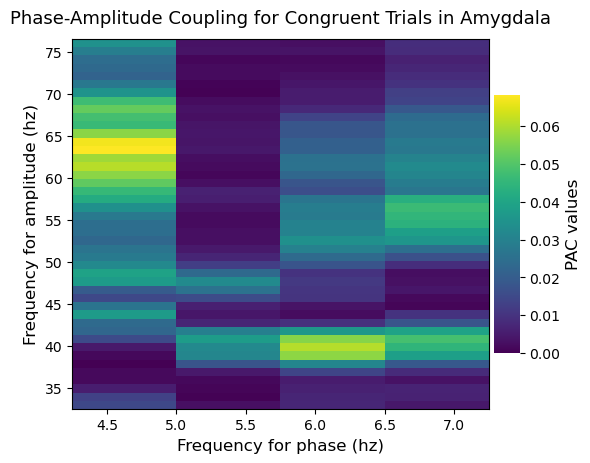

In [76]:
#AMYGDALA

# data_congruent should be the data array from epochs_congruent
data_congruent = epochs_congruent.get_data()

# Adjust the PAC object parameters
p = Pac(idpac=(6, 0, 0), f_pha=(4, 8, 0.5, 1), f_amp=(30, 80, 5, 1), dcomplex='hilbert', cycle=(3, 6), width=7)

# Specify the epoch and channel you want to analyze
specific_channel = 0  # Change this to the index of the channel you want to analyze
theta_min, theta_max = 4, 8  # Define the theta band
gamma_min, gamma_max = 30, 80  # Define the theta band

# Get the sampling frequency
sfreq = epochs_congruent.info['sfreq']

# Extract phase and amplitude data
phase_data = data_congruent[:, specific_channel, :].mean(axis=0)  # Extract the phase data (e.g., 4-8 Hz)
amplitude_data = data_congruent[:, specific_channel, :].mean(axis=0)  # Extract the amplitude data (e.g., 80-120 Hz)

#PHASE
# Filter the data in the theta band
theta_data = mne.filter.filter_data(phase_data, sfreq, theta_min, theta_max, method='iir')
#Notch Filter at 60 Hz
theta_data = mne.filter.notch_filter(phase_data, sfreq, freqs = np.arange(60, 241, 60))
# Compute the Hilbert transform to get the analytic signal
analytic_signal = hilbert(theta_data, axis=-1)
# Extract the phase of the analytic signal
data_phase = np.angle(analytic_signal)

#AMPLITUDE
# Filter the data in the theta band
gamma_data = mne.filter.filter_data(amplitude_data, sfreq, gamma_min, gamma_max, method='iir')
#Notch Filter at 60 Hz
gamma_data = mne.filter.notch_filter(amplitude_data, sfreq, freqs = np.arange(60, 241, 60))
# Compute the Hilbert transform to get the analytic signal
analytic_signal = hilbert(gamma_data, axis=-1)
# Extract the phase of the analytic signal
data_amplitude = np.angle(analytic_signal)

# Compute PAC
pac = p.filterfit(epochs.info['sfreq'], data_phase, data_amplitude)

# Plot the PAC
p.comodulogram(pac, title='Phase-Amplitude Coupling for Congruent Trials in Amygdala')
plt.show()

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/4161823241.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_congruent = epochs_congruent.get_data()
Phase Amplitude Coupling object defined


Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Setting up band-pass filter from 30 - 80 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 30.00, 80.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a o

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/4161823241.py:25: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  theta_data = mne.filter.notch_filter(phase_data, sfreq, freqs = np.arange(60, 241, 60))
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/4161823241.py:35: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  gamma_data = mne.filter.notch_filter(amplitude_data, sfreq, freqs = np.arange(60, 241, 60))
    extract phases (n_pha=4) and amplitudes (n_amps=45)
    true PAC estimation using Gaussian Copula PAC (gcPac)
WARNING | 3d pac array has been given as an input. Only 2d arrays are supported for plotting. Taking the mean across the last dimension


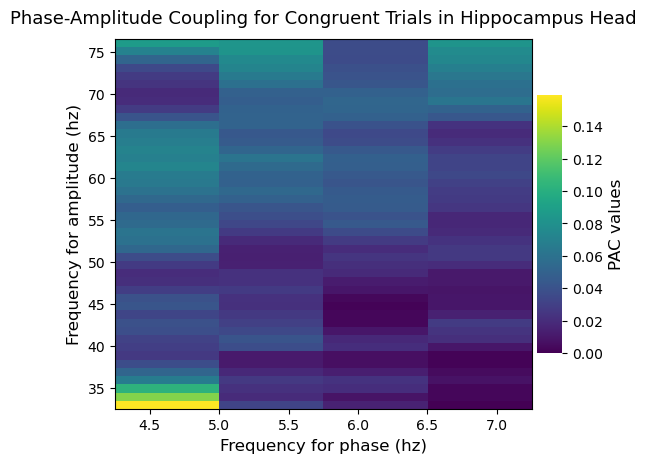

In [77]:
#HIPPOCAMPUS HEAD

# data_congruent should be the data array from epochs_congruent
data_congruent = epochs_congruent.get_data()

# Adjust the PAC object parameters
p = Pac(idpac=(6, 0, 0), f_pha=(4, 8, 0.5, 1), f_amp=(30, 80, 5, 1), dcomplex='hilbert', cycle=(3, 6), width=7)

# Specify the epoch and channel you want to analyze
specific_channel = 10  # Change this to the index of the channel you want to analyze
theta_min, theta_max = 4, 8  # Define the theta band
gamma_min, gamma_max = 30, 80  # Define the theta band

# Get the sampling frequency
sfreq = epochs_congruent.info['sfreq']

# Extract phase and amplitude data
phase_data = data_congruent[:, specific_channel, :].mean(axis=0)  # Extract the phase data (e.g., 4-8 Hz)
amplitude_data = data_congruent[:, specific_channel, :].mean(axis=0)  # Extract the amplitude data (e.g., 80-120 Hz)

#PHASE
# Filter the data in the theta band
theta_data = mne.filter.filter_data(phase_data, sfreq, theta_min, theta_max, method='iir')
#Notch Filter at 60 Hz
theta_data = mne.filter.notch_filter(phase_data, sfreq, freqs = np.arange(60, 241, 60))
# Compute the Hilbert transform to get the analytic signal
analytic_signal = hilbert(theta_data, axis=-1)
# Extract the phase of the analytic signal
data_phase = np.angle(analytic_signal)

#AMPLITUDE
# Filter the data in the theta band
gamma_data = mne.filter.filter_data(amplitude_data, sfreq, gamma_min, gamma_max, method='iir')
#Notch Filter at 60 Hz
gamma_data = mne.filter.notch_filter(amplitude_data, sfreq, freqs = np.arange(60, 241, 60))
# Compute the Hilbert transform to get the analytic signal
analytic_signal = hilbert(gamma_data, axis=-1)
# Extract the phase of the analytic signal
data_amplitude = np.angle(analytic_signal)

# Compute PAC
pac = p.filterfit(epochs.info['sfreq'], data_phase, data_amplitude)

# Plot the PAC
p.comodulogram(pac, title='Phase-Amplitude Coupling for Congruent Trials in Hippocampus Head')
plt.show()

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/1677717036.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_congruent = epochs_congruent.get_data()
Phase Amplitude Coupling object defined


Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Setting up band-pass filter from 30 - 80 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 30.00, 80.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a o

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/1677717036.py:25: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  theta_data = mne.filter.notch_filter(phase_data, sfreq, freqs = np.arange(60, 241, 60))
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/1677717036.py:35: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  gamma_data = mne.filter.notch_filter(amplitude_data, sfreq, freqs = np.arange(60, 241, 60))
    extract phases (n_pha=4) and amplitudes (n_amps=45)
    true PAC estimation using Gaussian Copula PAC (gcPac)
WARNING | 3d pac array has been given as an input. Only 2d arrays are supported for plotting. Taking the mean across the last dimension


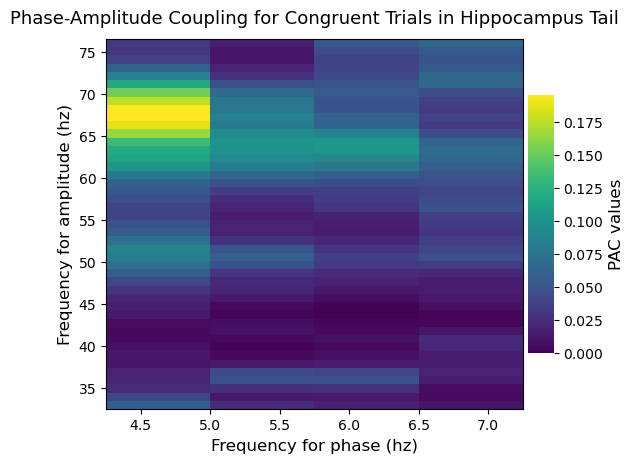

In [78]:
#HIPPOCAMPUS TAIL

# data_congruent should be the data array from epochs_congruent
data_congruent = epochs_congruent.get_data()

# Adjust the PAC object parameters
p = Pac(idpac=(6, 0, 0), f_pha=(4, 8, 0.5, 1), f_amp=(30, 80, 5, 1), dcomplex='hilbert', cycle=(3, 6), width=7)

# Specify the epoch and channel you want to analyze
specific_channel = 20  # Change this to the index of the channel you want to analyze
theta_min, theta_max = 4, 8  # Define the theta band
gamma_min, gamma_max = 30, 80  # Define the theta band

# Get the sampling frequency
sfreq = epochs_congruent.info['sfreq']

# Extract phase and amplitude data
phase_data = data_congruent[:, specific_channel, :].mean(axis=0)  # Extract the phase data (e.g., 4-8 Hz)
amplitude_data = data_congruent[:, specific_channel, :].mean(axis=0)  # Extract the amplitude data (e.g., 80-120 Hz)

#PHASE
# Filter the data in the theta band
theta_data = mne.filter.filter_data(phase_data, sfreq, theta_min, theta_max, method='iir')
#Notch Filter at 60 Hz
theta_data = mne.filter.notch_filter(phase_data, sfreq, freqs = np.arange(60, 241, 60))
# Compute the Hilbert transform to get the analytic signal
analytic_signal = hilbert(theta_data, axis=-1)
# Extract the phase of the analytic signal
data_phase = np.angle(analytic_signal)

#AMPLITUDE
# Filter the data in the theta band
gamma_data = mne.filter.filter_data(amplitude_data, sfreq, gamma_min, gamma_max, method='iir')
#Notch Filter at 60 Hz
gamma_data = mne.filter.notch_filter(amplitude_data, sfreq, freqs = np.arange(60, 241, 60))
# Compute the Hilbert transform to get the analytic signal
analytic_signal = hilbert(gamma_data, axis=-1)
# Extract the phase of the analytic signal
data_amplitude = np.angle(analytic_signal)

# Compute PAC
pac = p.filterfit(epochs.info['sfreq'], data_phase, data_amplitude)

# Plot the PAC
p.comodulogram(pac, title='Phase-Amplitude Coupling for Congruent Trials in Hippocampus Tail')
plt.show()

Incongruent Trials

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/3323526784.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_incongruent = epochs_incongruent.get_data()
Phase Amplitude Coupling object defined


Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Setting up band-pass filter from 30 - 80 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 30.00, 80.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a o

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/3323526784.py:25: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  theta_data = mne.filter.notch_filter(phase_data, sfreq, freqs = np.arange(60, 241, 60))
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/3323526784.py:35: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  gamma_data = mne.filter.notch_filter(amplitude_data, sfreq, freqs = np.arange(60, 241, 60))
    extract phases (n_pha=4) and amplitudes (n_amps=45)
    true PAC estimation using Gaussian Copula PAC (gcPac)
WARNING | 3d pac array has been given as an input. Only 2d arrays are supported for plotting. Taking the mean across the last dimension


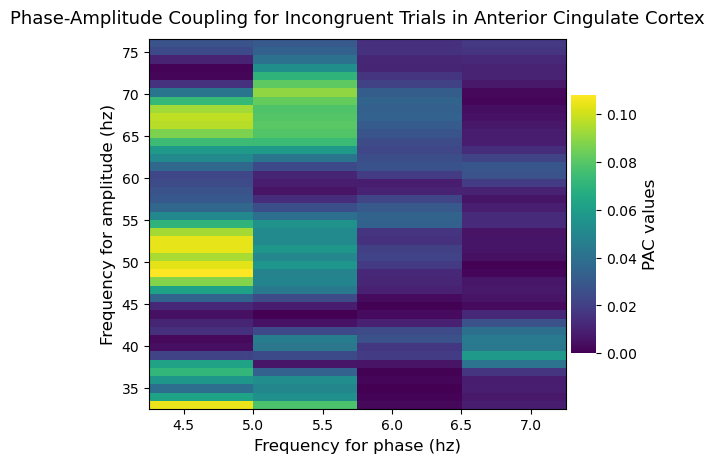

In [79]:
#ANTERIOR CINGULATE CORTEX

# data_incongruent should be the data array from epochs_incongruent
data_incongruent = epochs_incongruent.get_data()

# Adjust the PAC object parameters
p = Pac(idpac=(6, 0, 0), f_pha=(4, 8, 0.5, 1), f_amp=(30, 80, 5, 1), dcomplex='hilbert', cycle=(3, 6), width=7)

# Specify the epoch and channel you want to analyze
specific_channel = 38  # Change this to the index of the channel you want to analyze
theta_min, theta_max = 4, 8  # Define the theta band
gamma_min, gamma_max = 30, 80  # Define the theta band

# Get the sampling frequency
sfreq = epochs_incongruent.info['sfreq']

# Extract phase and amplitude data
phase_data = data_incongruent[:, specific_channel, :].mean(axis=0)  # Extract the phase data (e.g., 4-8 Hz)
amplitude_data = data_incongruent[:, specific_channel, :].mean(axis=0)  # Extract the amplitude data (e.g., 80-120 Hz)

#PHASE
# Filter the data in the theta band
theta_data = mne.filter.filter_data(phase_data, sfreq, theta_min, theta_max, method='iir')
#Notch Filter at 60 Hz
theta_data = mne.filter.notch_filter(phase_data, sfreq, freqs = np.arange(60, 241, 60))
# Compute the Hilbert transform to get the analytic signal
analytic_signal = hilbert(theta_data, axis=-1)
# Extract the phase of the analytic signal
data_phase = np.angle(analytic_signal)

#AMPLITUDE
# Filter the data in the theta band
gamma_data = mne.filter.filter_data(amplitude_data, sfreq, gamma_min, gamma_max, method='iir')
#Notch Filter at 60 Hz
gamma_data = mne.filter.notch_filter(amplitude_data, sfreq, freqs = np.arange(60, 241, 60))
# Compute the Hilbert transform to get the analytic signal
analytic_signal = hilbert(gamma_data, axis=-1)
# Extract the phase of the analytic signal
data_amplitude = np.angle(analytic_signal)

# Compute PAC
pac = p.filterfit(epochs.info['sfreq'], data_phase, data_amplitude)

# Plot the PAC
p.comodulogram(pac, title='Phase-Amplitude Coupling for Incongruent Trials in Anterior Cingulate Cortex')
plt.show()

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/2667087341.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_incongruent = epochs_incongruent.get_data()
Phase Amplitude Coupling object defined


Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Setting up band-pass filter from 30 - 80 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 30.00, 80.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a o

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/2667087341.py:25: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  theta_data = mne.filter.notch_filter(phase_data, sfreq, freqs = np.arange(60, 241, 60))
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/2667087341.py:35: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  gamma_data = mne.filter.notch_filter(amplitude_data, sfreq, freqs = np.arange(60, 241, 60))
    extract phases (n_pha=4) and amplitudes (n_amps=45)
    true PAC estimation using Gaussian Copula PAC (gcPac)
WARNING | 3d pac array has been given as an input. Only 2d arrays are supported for plotting. Taking the mean across the last dimension


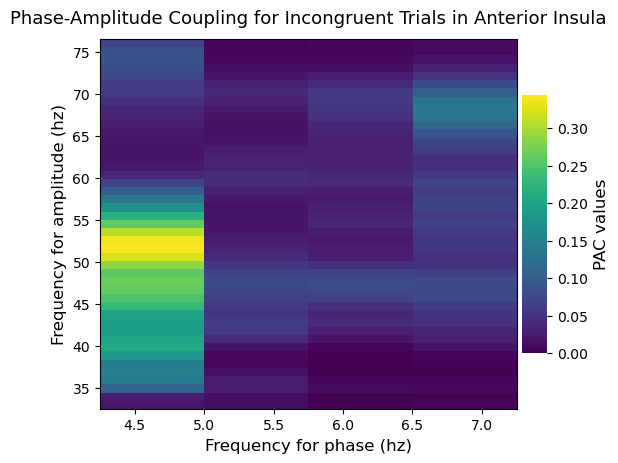

In [80]:
#ANTERIOR INSULA_L

# data_incongruent should be the data array from epochs_incongruent
data_incongruent = epochs_incongruent.get_data()

# Adjust the PAC object parameters
p = Pac(idpac=(6, 0, 0), f_pha=(4, 8, 0.5, 1), f_amp=(30, 80, 5, 1), dcomplex='hilbert', cycle=(3, 6), width=7)

# Specify the epoch and channel you want to analyze
specific_channel = 80  # Change this to the index of the channel you want to analyze
theta_min, theta_max = 4, 8  # Define the theta band
gamma_min, gamma_max = 30, 80  # Define the theta band

# Get the sampling frequency
sfreq = epochs_incongruent.info['sfreq']

# Extract phase and amplitude data
phase_data = data_incongruent[:, specific_channel, :].mean(axis=0)  # Extract the phase data (e.g., 4-8 Hz)
amplitude_data = data_incongruent[:, specific_channel, :].mean(axis=0)  # Extract the amplitude data (e.g., 80-120 Hz)

#PHASE
# Filter the data in the theta band
theta_data = mne.filter.filter_data(phase_data, sfreq, theta_min, theta_max, method='iir')
#Notch Filter at 60 Hz
theta_data = mne.filter.notch_filter(phase_data, sfreq, freqs = np.arange(60, 241, 60))
# Compute the Hilbert transform to get the analytic signal
analytic_signal = hilbert(theta_data, axis=-1)
# Extract the phase of the analytic signal
data_phase = np.angle(analytic_signal)

#AMPLITUDE
# Filter the data in the theta band
gamma_data = mne.filter.filter_data(amplitude_data, sfreq, gamma_min, gamma_max, method='iir')
#Notch Filter at 60 Hz
gamma_data = mne.filter.notch_filter(amplitude_data, sfreq, freqs = np.arange(60, 241, 60))
# Compute the Hilbert transform to get the analytic signal
analytic_signal = hilbert(gamma_data, axis=-1)
# Extract the phase of the analytic signal
data_amplitude = np.angle(analytic_signal)

# Compute PAC
pac = p.filterfit(epochs.info['sfreq'], data_phase, data_amplitude)

# Plot the PAC
p.comodulogram(pac, title='Phase-Amplitude Coupling for Incongruent Trials in Anterior Insula')
plt.show()

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/838407283.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_incongruent = epochs_incongruent.get_data()
Phase Amplitude Coupling object defined


Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Setting up band-pass filter from 30 - 80 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 30.00, 80.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a o

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/838407283.py:25: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  theta_data = mne.filter.notch_filter(phase_data, sfreq, freqs = np.arange(60, 241, 60))
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/838407283.py:35: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  gamma_data = mne.filter.notch_filter(amplitude_data, sfreq, freqs = np.arange(60, 241, 60))
    extract phases (n_pha=4) and amplitudes (n_amps=45)
    true PAC estimation using Gaussian Copula PAC (gcPac)
WARNING | 3d pac array has been given as an input. Only 2d arrays are supported for plotting. Taking the mean across the last dimension


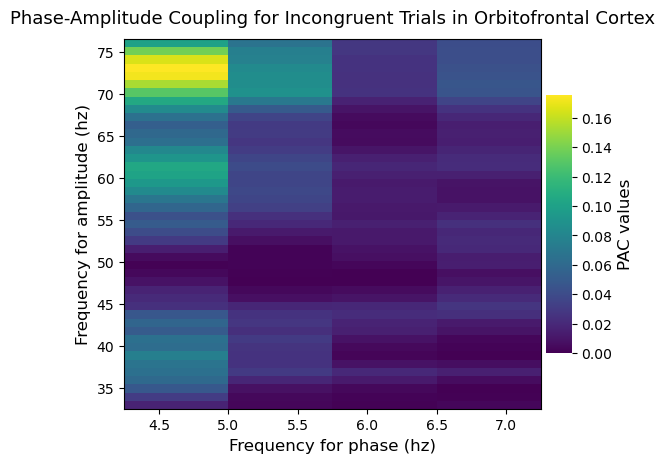

In [81]:
#ORBITOFRONTAL CORTEX

# data_incongruent should be the data array from epochs_incongruent
data_incongruent = epochs_incongruent.get_data()

# Adjust the PAC object parameters
p = Pac(idpac=(6, 0, 0), f_pha=(4, 8, 0.5, 1), f_amp=(30, 80, 5, 1), dcomplex='hilbert', cycle=(3, 6), width=7)

# Specify the epoch and channel you want to analyze
specific_channel = 61  # Change this to the index of the channel you want to analyze
theta_min, theta_max = 4, 8  # Define the theta band
gamma_min, gamma_max = 30, 80  # Define the theta band

# Get the sampling frequency
sfreq = epochs_incongruent.info['sfreq']

# Extract phase and amplitude data
phase_data = data_incongruent[:, specific_channel, :].mean(axis=0)  # Extract the phase data (e.g., 4-8 Hz)
amplitude_data = data_incongruent[:, specific_channel, :].mean(axis=0)  # Extract the amplitude data (e.g., 80-120 Hz)

#PHASE
# Filter the data in the theta band
theta_data = mne.filter.filter_data(phase_data, sfreq, theta_min, theta_max, method='iir')
#Notch Filter at 60 Hz
theta_data = mne.filter.notch_filter(phase_data, sfreq, freqs = np.arange(60, 241, 60))
# Compute the Hilbert transform to get the analytic signal
analytic_signal = hilbert(theta_data, axis=-1)
# Extract the phase of the analytic signal
data_phase = np.angle(analytic_signal)

#AMPLITUDE
# Filter the data in the theta band
gamma_data = mne.filter.filter_data(amplitude_data, sfreq, gamma_min, gamma_max, method='iir')
#Notch Filter at 60 Hz
gamma_data = mne.filter.notch_filter(amplitude_data, sfreq, freqs = np.arange(60, 241, 60))
# Compute the Hilbert transform to get the analytic signal
analytic_signal = hilbert(gamma_data, axis=-1)
# Extract the phase of the analytic signal
data_amplitude = np.angle(analytic_signal)

# Compute PAC
pac = p.filterfit(epochs.info['sfreq'], data_phase, data_amplitude)

# Plot the PAC
p.comodulogram(pac, title='Phase-Amplitude Coupling for Incongruent Trials in Orbitofrontal Cortex')
plt.show()

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/35199049.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_incongruent = epochs_incongruent.get_data()
Phase Amplitude Coupling object defined


Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Setting up band-pass filter from 30 - 80 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 30.00, 80.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a o

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/35199049.py:25: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  theta_data = mne.filter.notch_filter(phase_data, sfreq, freqs = np.arange(60, 241, 60))
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/35199049.py:35: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  gamma_data = mne.filter.notch_filter(amplitude_data, sfreq, freqs = np.arange(60, 241, 60))
    extract phases (n_pha=4) and amplitudes (n_amps=45)
    true PAC estimation using Gaussian Copula PAC (gcPac)
WARNING | 3d pac array has been given as an input. Only 2d arrays are supported for plotting. Taking the mean across the last dimension


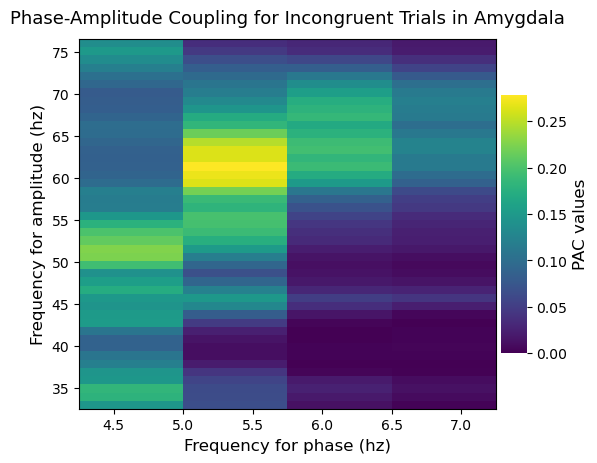

In [82]:
#AMYGDALA

# data_incongruent should be the data array from epochs_incongruent
data_incongruent = epochs_incongruent.get_data()

# Adjust the PAC object parameters
p = Pac(idpac=(6, 0, 0), f_pha=(4, 8, 0.5, 1), f_amp=(30, 80, 5, 1), dcomplex='hilbert', cycle=(3, 6), width=7)

# Specify the epoch and channel you want to analyze
specific_channel = 0  # Change this to the index of the channel you want to analyze
theta_min, theta_max = 4, 8  # Define the theta band
gamma_min, gamma_max = 30, 80  # Define the theta band

# Get the sampling frequency
sfreq = epochs_incongruent.info['sfreq']

# Extract phase and amplitude data
phase_data = data_incongruent[:, specific_channel, :].mean(axis=0)  # Extract the phase data (e.g., 4-8 Hz)
amplitude_data = data_incongruent[:, specific_channel, :].mean(axis=0)  # Extract the amplitude data (e.g., 80-120 Hz)

#PHASE
# Filter the data in the theta band
theta_data = mne.filter.filter_data(phase_data, sfreq, theta_min, theta_max, method='iir')
#Notch Filter at 60 Hz
theta_data = mne.filter.notch_filter(phase_data, sfreq, freqs = np.arange(60, 241, 60))
# Compute the Hilbert transform to get the analytic signal
analytic_signal = hilbert(theta_data, axis=-1)
# Extract the phase of the analytic signal
data_phase = np.angle(analytic_signal)

#AMPLITUDE
# Filter the data in the theta band
gamma_data = mne.filter.filter_data(amplitude_data, sfreq, gamma_min, gamma_max, method='iir')
#Notch Filter at 60 Hz
gamma_data = mne.filter.notch_filter(amplitude_data, sfreq, freqs = np.arange(60, 241, 60))
# Compute the Hilbert transform to get the analytic signal
analytic_signal = hilbert(gamma_data, axis=-1)
# Extract the phase of the analytic signal
data_amplitude = np.angle(analytic_signal)

# Compute PAC
pac = p.filterfit(epochs.info['sfreq'], data_phase, data_amplitude)

# Plot the PAC
p.comodulogram(pac, title='Phase-Amplitude Coupling for Incongruent Trials in Amygdala')
plt.show()

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/3399692625.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_incongruent = epochs_incongruent.get_data()
Phase Amplitude Coupling object defined


Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Setting up band-pass filter from 30 - 80 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 30.00, 80.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a o

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/3399692625.py:25: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  theta_data = mne.filter.notch_filter(phase_data, sfreq, freqs = np.arange(60, 241, 60))
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/3399692625.py:35: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  gamma_data = mne.filter.notch_filter(amplitude_data, sfreq, freqs = np.arange(60, 241, 60))
    extract phases (n_pha=4) and amplitudes (n_amps=45)
    true PAC estimation using Gaussian Copula PAC (gcPac)
WARNING | 3d pac array has been given as an input. Only 2d arrays are supported for plotting. Taking the mean across the last dimension


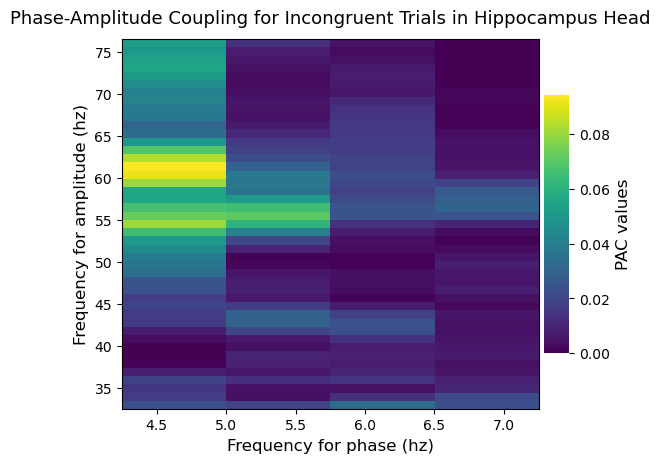

In [83]:
#HIPPOCAMPUS HEAD

# data_incongruent should be the data array from epochs_incongruent
data_incongruent = epochs_incongruent.get_data()

# Adjust the PAC object parameters
p = Pac(idpac=(6, 0, 0), f_pha=(4, 8, 0.5, 1), f_amp=(30, 80, 5, 1), dcomplex='hilbert', cycle=(3, 6), width=7)

# Specify the epoch and channel you want to analyze
specific_channel = 10  # Change this to the index of the channel you want to analyze
theta_min, theta_max = 4, 8  # Define the theta band
gamma_min, gamma_max = 30, 80  # Define the theta band

# Get the sampling frequency
sfreq = epochs_incongruent.info['sfreq']

# Extract phase and amplitude data
phase_data = data_incongruent[:, specific_channel, :].mean(axis=0)  # Extract the phase data (e.g., 4-8 Hz)
amplitude_data = data_incongruent[:, specific_channel, :].mean(axis=0)  # Extract the amplitude data (e.g., 80-120 Hz)

#PHASE
# Filter the data in the theta band
theta_data = mne.filter.filter_data(phase_data, sfreq, theta_min, theta_max, method='iir')
#Notch Filter at 60 Hz
theta_data = mne.filter.notch_filter(phase_data, sfreq, freqs = np.arange(60, 241, 60))
# Compute the Hilbert transform to get the analytic signal
analytic_signal = hilbert(theta_data, axis=-1)
# Extract the phase of the analytic signal
data_phase = np.angle(analytic_signal)

#AMPLITUDE
# Filter the data in the theta band
gamma_data = mne.filter.filter_data(amplitude_data, sfreq, gamma_min, gamma_max, method='iir')
#Notch Filter at 60 Hz
gamma_data = mne.filter.notch_filter(amplitude_data, sfreq, freqs = np.arange(60, 241, 60))
# Compute the Hilbert transform to get the analytic signal
analytic_signal = hilbert(gamma_data, axis=-1)
# Extract the phase of the analytic signal
data_amplitude = np.angle(analytic_signal)

# Compute PAC
pac = p.filterfit(epochs.info['sfreq'], data_phase, data_amplitude)

# Plot the PAC
p.comodulogram(pac, title='Phase-Amplitude Coupling for Incongruent Trials in Hippocampus Head')
plt.show()

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/3242850848.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_incongruent = epochs_incongruent.get_data()
Phase Amplitude Coupling object defined


Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)

Setting up band-pass filter from 30 - 80 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 30.00, 80.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a o

/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/3242850848.py:25: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  theta_data = mne.filter.notch_filter(phase_data, sfreq, freqs = np.arange(60, 241, 60))
/var/folders/_9/b52xzjr17jg846fw21mn42tr0000gn/T/ipykernel_59342/3242850848.py:35: RuntimeWarning: filter_length (6759) is longer than the signal (1742), distortion is likely. Reduce filter length or filter a longer signal.
  gamma_data = mne.filter.notch_filter(amplitude_data, sfreq, freqs = np.arange(60, 241, 60))
    extract phases (n_pha=4) and amplitudes (n_amps=45)
    true PAC estimation using Gaussian Copula PAC (gcPac)
WARNING | 3d pac array has been given as an input. Only 2d arrays are supported for plotting. Taking the mean across the last dimension


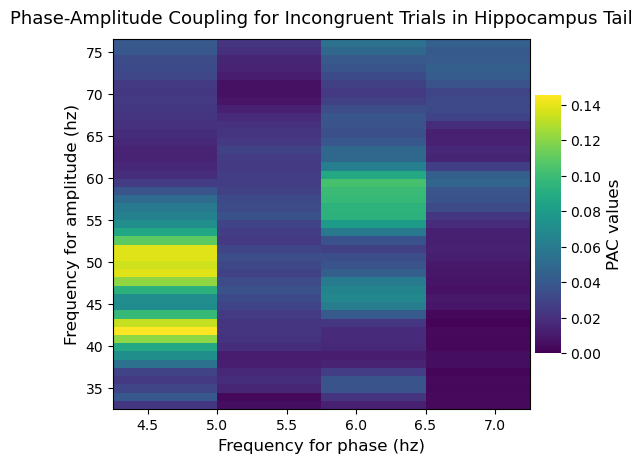

In [84]:
#HIPPOCAMPUS TAIL

# data_incongruent should be the data array from epochs_incongruent
data_incongruent = epochs_incongruent.get_data()

# Adjust the PAC object parameters
p = Pac(idpac=(6, 0, 0), f_pha=(4, 8, 0.5, 1), f_amp=(30, 80, 5, 1), dcomplex='hilbert', cycle=(3, 6), width=7)

# Specify the epoch and channel you want to analyze
specific_channel = 20  # Change this to the index of the channel you want to analyze
theta_min, theta_max = 4, 8  # Define the theta band
gamma_min, gamma_max = 30, 80  # Define the theta band

# Get the sampling frequency
sfreq = epochs_incongruent.info['sfreq']

# Extract phase and amplitude data
phase_data = data_incongruent[:, specific_channel, :].mean(axis=0)  # Extract the phase data (e.g., 4-8 Hz)
amplitude_data = data_incongruent[:, specific_channel, :].mean(axis=0)  # Extract the amplitude data (e.g., 80-120 Hz)

#PHASE
# Filter the data in the theta band
theta_data = mne.filter.filter_data(phase_data, sfreq, theta_min, theta_max, method='iir')
#Notch Filter at 60 Hz
theta_data = mne.filter.notch_filter(phase_data, sfreq, freqs = np.arange(60, 241, 60))
# Compute the Hilbert transform to get the analytic signal
analytic_signal = hilbert(theta_data, axis=-1)
# Extract the phase of the analytic signal
data_phase = np.angle(analytic_signal)

#AMPLITUDE
# Filter the data in the theta band
gamma_data = mne.filter.filter_data(amplitude_data, sfreq, gamma_min, gamma_max, method='iir')
#Notch Filter at 60 Hz
gamma_data = mne.filter.notch_filter(amplitude_data, sfreq, freqs = np.arange(60, 241, 60))
# Compute the Hilbert transform to get the analytic signal
analytic_signal = hilbert(gamma_data, axis=-1)
# Extract the phase of the analytic signal
data_amplitude = np.angle(analytic_signal)

# Compute PAC
pac = p.filterfit(epochs.info['sfreq'], data_phase, data_amplitude)

# Plot the PAC
p.comodulogram(pac, title='Phase-Amplitude Coupling for Incongruent Trials in Hippocampus Tail')
plt.show()

# Synthetic Data Analysis for Practice!

[........................................] 100% | 34.04 sec | comodulogram: DAR(10, 1) 
[........................................] 100% | 34.04 sec | comodulogram: DAR(10, 1) 

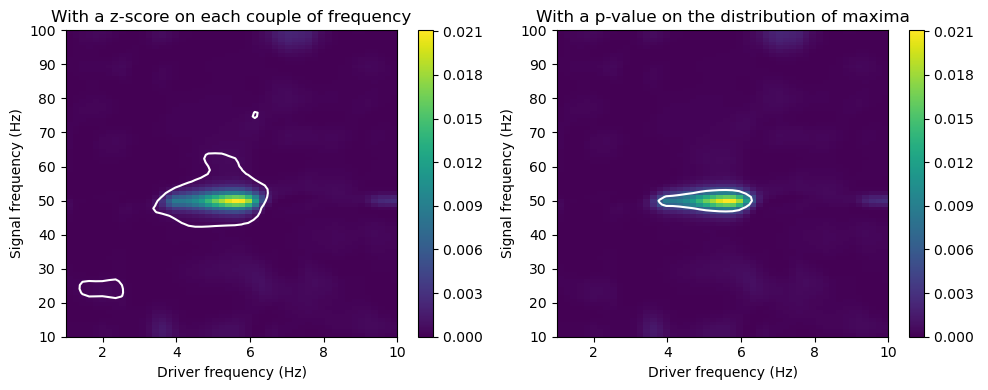

In [49]:
#Surrogate Analysis
from pactools import simulate_pac
from pactools import Comodulogram

fs = 200.  # Hz
high_fq = 50.0  # Hz
low_fq = 5.0  # Hz
low_fq_width = 1.0  # Hz

n_points = 1000
noise_level = 0.4

signal = simulate_pac(n_points=n_points, fs=fs, high_fq=high_fq, low_fq=low_fq,
                      low_fq_width=low_fq_width, noise_level=noise_level,
                      random_state=0)

low_fq_range = np.linspace(1, 10, 50)
method = 'duprelatour'  # or 'tort', 'ozkurt', 'penny', 'colgin', ...
n_surrogates = 200
n_jobs = 1

estimator = Comodulogram(fs=fs, low_fq_range=low_fq_range,
                         low_fq_width=low_fq_width, method=method,
                         n_surrogates=n_surrogates, progress_bar=True,
                         n_jobs=n_jobs)
estimator.fit(signal)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

z_score = 4.
estimator.plot(contour_method='z_score', contour_level=z_score,
               titles=['With a z-score on each couple of frequency'],
               axs=[axs[0]])

p_value = 0.05
estimator.plot(contour_method='comod_max', contour_level=p_value,
               titles=['With a p-value on the distribution of maxima'],
               axs=[axs[1]])

plt.show()

In [50]:
# Download example data
data = nk.data("bio_eventrelated_100hz")

# Preprocess the data (filter, find peaks, etc.)
processed_data, info = nk.bio_process(ecg=data["ECG"], rsp=data["RSP"], eda=data["EDA"], sampling_rate=100)

# Compute relevant features
results = nk.bio_analyze(processed_data, sampling_rate=100)


/opt/anaconda3/lib/python3.12/site-packages/scipy/signal/_filter_design.py:2898: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  wo = float(wo)
/opt/anaconda3/lib/python3.12/site-packages/scipy/signal/_filter_design.py:2821: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  wo = float(wo)  # Avoid int wraparound
/opt/anaconda3/lib/python3.12/site-packages/scipy/signal/_filter_design.py:2898: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  wo = float(wo)
/opt/anaconda3/lib/

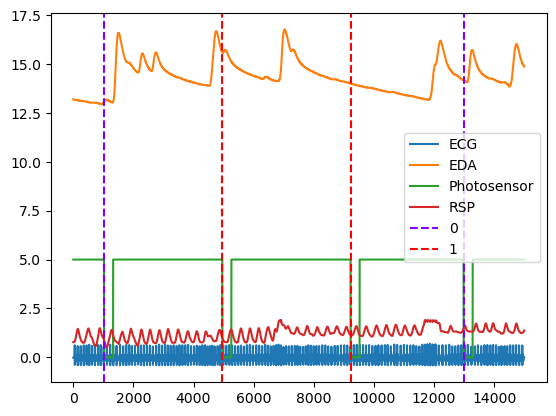

In [51]:
condition_list = ["Negative", "Neutral", "Neutral", "Negative"]
# Find events
events = nk.events_find(data["Photosensor"], threshold_keep='below', event_conditions=condition_list)
events
# Plot the location of event with the signals
plot = nk.events_plot(events, data)
plt.show()

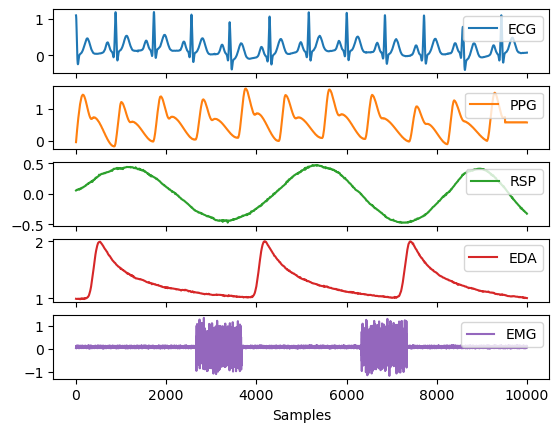

In [52]:

# Generate synthetic signals
ecg = nk.ecg_simulate(duration=10, heart_rate=70)
ppg = nk.ppg_simulate(duration=10, heart_rate=70)
rsp = nk.rsp_simulate(duration=10, respiratory_rate=15)
eda = nk.eda_simulate(duration=10, scr_number=3)
emg = nk.emg_simulate(duration=10, burst_number=2)

# Visualise biosignals
data = pd.DataFrame({"ECG": ecg,
                     "PPG": ppg,
                     "RSP": rsp,
                     "EDA": eda,
                     "EMG": emg})
nk.signal_plot(data, subplots=True)
plt.show()

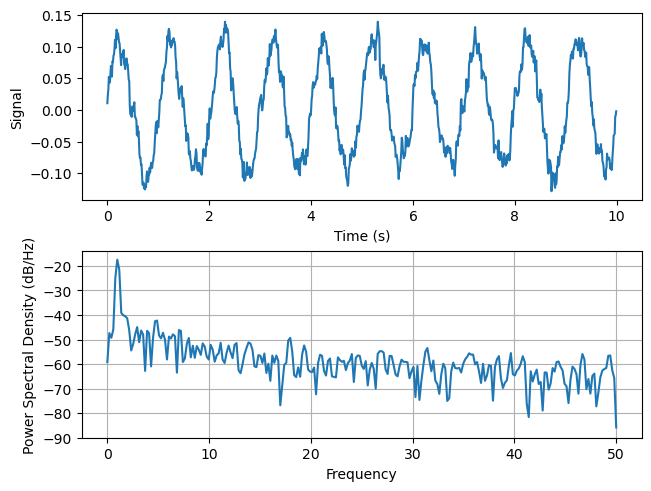

In [53]:
#Fixing random state for reproducibility
np.random.seed(19680801)

dt = 0.01
t = np.arange(0, 10, dt)
nse = np.random.randn(len(t))
r = np.exp(-t / 0.05)

cnse = np.convolve(nse, r) * dt
cnse = cnse[:len(t)]
s = 0.1 * np.sin(2 * np.pi * t) + cnse

fig, (ax0, ax1) = plt.subplots(2, 1, layout='constrained')
ax0.plot(t, s)
ax0.set_xlabel('Time (s)')
ax0.set_ylabel('Signal')
ax1.psd(s, 512, 1 / dt)

plt.show()

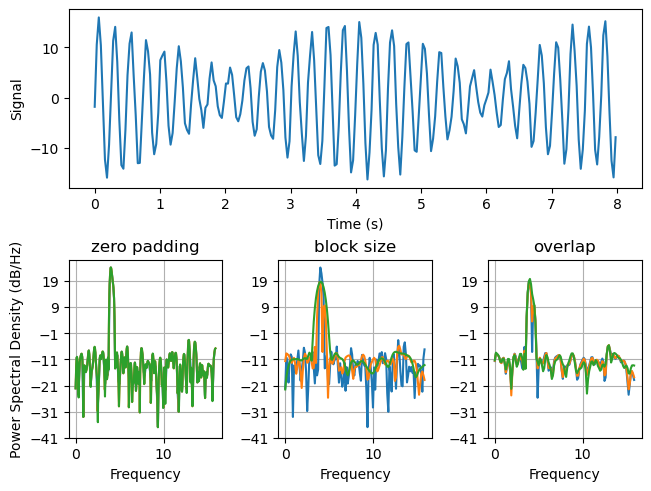

In [54]:
dt = np.pi / 100.
fs = 1. / dt
t = np.arange(0, 8, dt)
y = 10. * np.sin(2 * np.pi * 4 * t) + 5. * np.sin(2 * np.pi * 4.25 * t)
y = y + np.random.randn(*t.shape)

# Plot the raw time series
fig, axs = plt.subplot_mosaic([
    ['signal', 'signal', 'signal'],
    ['zero padding', 'block size', 'overlap'],
], layout='constrained')

axs['signal'].plot(t, y)
axs['signal'].set_xlabel('Time (s)')
axs['signal'].set_ylabel('Signal')

# Plot the PSD with different amounts of zero padding. This uses the entire
# time series at once
axs['zero padding'].psd(y, NFFT=len(t), pad_to=len(t), Fs=fs)
axs['zero padding'].psd(y, NFFT=len(t), pad_to=len(t) * 2, Fs=fs)
axs['zero padding'].psd(y, NFFT=len(t), pad_to=len(t) * 4, Fs=fs)

# Plot the PSD with different block sizes, Zero pad to the length of the
# original data sequence.
axs['block size'].psd(y, NFFT=len(t), pad_to=len(t), Fs=fs)
axs['block size'].psd(y, NFFT=len(t) // 2, pad_to=len(t), Fs=fs)
axs['block size'].psd(y, NFFT=len(t) // 4, pad_to=len(t), Fs=fs)
axs['block size'].set_ylabel('')

# Plot the PSD with different amounts of overlap between blocks
axs['overlap'].psd(y, NFFT=len(t) // 2, pad_to=len(t), noverlap=0, Fs=fs)
axs['overlap'].psd(y, NFFT=len(t) // 2, pad_to=len(t),
                   noverlap=int(0.025 * len(t)), Fs=fs)
axs['overlap'].psd(y, NFFT=len(t) // 2, pad_to=len(t),
                   noverlap=int(0.1 * len(t)), Fs=fs)
axs['overlap'].set_ylabel('')
axs['overlap'].set_title('overlap')

for title, ax in axs.items():
    if title == 'signal':
        continue

    ax.set_title(title)
    ax.sharex(axs['zero padding'])
    ax.sharey(axs['zero padding'])

plt.show()

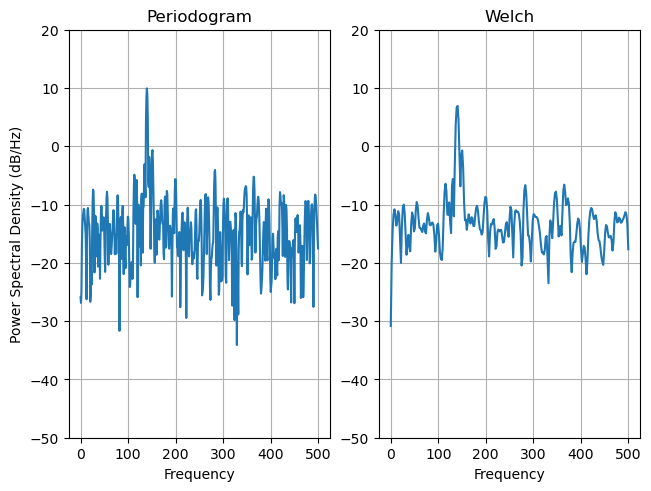

In [55]:
fs = 1000
t = np.linspace(0, 0.3, 301)
A = np.array([2, 8]).reshape(-1, 1)
f = np.array([150, 140]).reshape(-1, 1)
xn = (A * np.sin(2 * np.pi * f * t)).sum(axis=0)
xn += 5 * np.random.randn(*t.shape)

fig, (ax0, ax1) = plt.subplots(ncols=2, layout='constrained')

yticks = np.arange(-50, 30, 10)
yrange = (yticks[0], yticks[-1])
xticks = np.arange(0, 550, 100)

ax0.psd(xn, NFFT=301, Fs=fs, window=mlab.window_none, pad_to=1024,
        scale_by_freq=True)
ax0.set_title('Periodogram')
ax0.set_yticks(yticks)
ax0.set_xticks(xticks)
ax0.grid(True)
ax0.set_ylim(yrange)

ax1.psd(xn, NFFT=150, Fs=fs, window=mlab.window_none, pad_to=512, noverlap=75,
        scale_by_freq=True)
ax1.set_title('Welch')
ax1.set_xticks(xticks)
ax1.set_yticks(yticks)
ax1.set_ylabel('')  # overwrite the y-label added by `psd`
ax1.grid(True)
ax1.set_ylim(yrange)

plt.show()

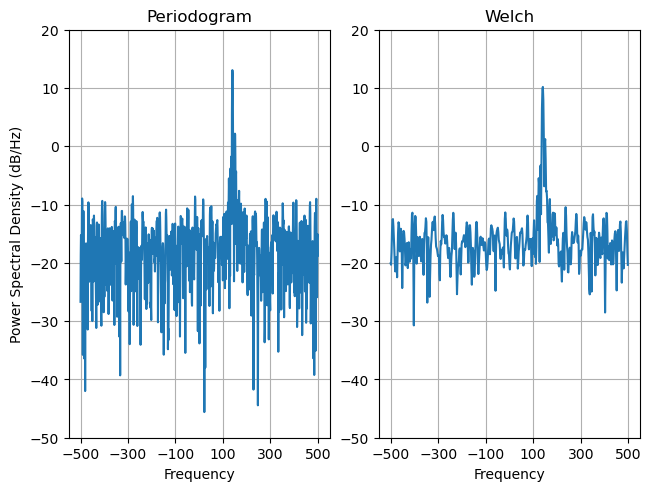

In [56]:
prng = np.random.RandomState(19680801)  # to ensure reproducibility

fs = 1000
t = np.linspace(0, 0.3, 301)
A = np.array([2, 8]).reshape(-1, 1)
f = np.array([150, 140]).reshape(-1, 1)
xn = (A * np.exp(2j * np.pi * f * t)).sum(axis=0) + 5 * prng.randn(*t.shape)

fig, (ax0, ax1) = plt.subplots(ncols=2, layout='constrained')

yticks = np.arange(-50, 30, 10)
yrange = (yticks[0], yticks[-1])
xticks = np.arange(-500, 550, 200)

ax0.psd(xn, NFFT=301, Fs=fs, window=mlab.window_none, pad_to=1024,
        scale_by_freq=True)
ax0.set_title('Periodogram')
ax0.set_yticks(yticks)
ax0.set_xticks(xticks)
ax0.grid(True)
ax0.set_ylim(yrange)

ax1.psd(xn, NFFT=150, Fs=fs, window=mlab.window_none, pad_to=512, noverlap=75,
        scale_by_freq=True)
ax1.set_title('Welch')
ax1.set_xticks(xticks)
ax1.set_yticks(yticks)
ax1.set_ylabel('')  # overwrite the y-label added by `psd`
ax1.grid(True)
ax1.set_ylim(yrange)

plt.show()